In [1]:
import torch
import os

In [2]:
import itertools

In [3]:
import pandas as pd

In [4]:
import numpy as np

In [5]:
import seaborn as sns

In [6]:
import matplotlib.pyplot as plt

In [7]:
import plotly.graph_objects as go

In [59]:
from plotly.subplots import make_subplots


In [8]:
from pathlib import Path

In [9]:
from helpers_mod import root as root_folder
from transformers_mod import Config, Transformer

In [10]:
from devinterp.zoo.arithmetic import ModularArithmeticConfig
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD

In [11]:
from devinterp.optim.sgnht import SGNHT

In [12]:
from torch.nn import functional as F

In [13]:
from torch import nn

In [14]:
from itertools import product

In [15]:
from copy import deepcopy

In [16]:
from plot import add_axis_toggle

In [17]:
%load_ext autoreload
%autoreload 2

In [18]:
t_device = torch.device("cuda")

In [19]:
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

In [20]:
PRIMARY, SECONDARY, TERTIARY = sns.color_palette("deep")[:3]

In [21]:
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]

In [22]:
pos_dict = {'memorization': [1500, 7000, 12000], 'circuit_formation': [1500 , 2200], 'cleanup': [1400, 1800]}

In [23]:
# from https://github.com/timaeus-research/devinterp/blob/main/examples/grokking.ipynb
def cross_entropy_last_token(outputs, targets, reduction="mean"):
    """
    Wrapper around cross entropy loss because we only care about the last number predicted.
    """
    # Only look at predictions of last numbers
    outputs = outputs[:, -1]

    # Compute individual and summed losses for final number
    logprobs = F.log_softmax(outputs.to(torch.float32), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=targets.unsqueeze(1), dim=-1)

    if reduction == "mean":
        loss = -torch.mean(prediction_logprobs)
    elif reduction == "sum":
        loss = -torch.sum(prediction_logprobs)
    else:
        raise ValueError("Invalid reduction argument.")

    return loss

In [24]:
# modified from grokking notebook
def make_rlct_evals(
    trainloader,
    num_draws=20,
    num_chains=5,
    num_cores=NUM_CORES,
    lr=1e-7,
    noise_level=1.0,
    weight_decay=3e-7,
    elasticity=1.0,
    repeats=5,
    pbar=False,
):

    optimizer_kwargs = dict(
        lr=lr,
        noise_level=noise_level,
        weight_decay=weight_decay,
        elasticity=elasticity,
        temperature="adaptive",
        num_samples=len(trainloader.dataset),
    )

    def eval_rlct(model: nn.Module):
        return estimate_learning_coeff(
            model,
            trainloader,
            cross_entropy_last_token,
            SGLD,
            optimizer_kwargs,
            num_draws=num_draws,
            num_chains=num_chains,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            cores=num_cores,
            pbar=pbar,
            device=t_device,
        )

    def eval_rlct_repeated(model):
        # print(model)
        # iterator = zip(range(10), itertools.cycle(trainloader))
        # device= torch.device("cuda")
        # for i, (xs, ys) in iterator:
        #     xs, ys = xs.to(device), ys.to(device)
        #     y_preds = model(xs)
        #     loss = cross_entropy_last_token(y_preds, ys)
        #     print(loss)
        results = {f"rlct/{i}": eval_rlct(model).item() for i in range(repeats)}
        print(results)
        rlcts = list(results.values())
        print(rlcts)
        results["rlct/mean"] = np.mean(rlcts).item()
        results["rlct/std"] = np.std(rlcts).item()

        return results

    return eval_rlct_repeated


In [25]:
# modified from grokking notebook
def eval_rlcts_over_time(
    trainloader,
    model,
    checkpoint_paths,
    num_draws=20,
    num_chains=5,
    num_cores=NUM_CORES,
    lr=1e-7,
    noise_level=1.0,
    weight_decay=3e-7,
    elasticity=1.0,
    repeats=5,
    pbar=False,
):
    evals = []
    eval_rlcts = make_rlct_evals(
        trainloader,
        num_draws=num_draws,
        num_chains=num_chains,
        num_cores=num_cores,
        lr=lr,
        noise_level=noise_level,
        weight_decay=weight_decay,
        elasticity=elasticity,
        repeats=repeats,
        pbar=True,
    )

    # wandb.init(project=PROJECT, entity=ENTITY)

    for checkpoint_path in checkpoint_paths:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        evals.append(eval_rlcts(model))
        # wandb.log(evals[-1], step=step)
        # print(yaml.dump(evals[-1]))

    # wandb.finish()

    return pd.DataFrame(evals)

In [26]:
# from https://github.com/timaeus-research/devinterp/blob/main/examples/grokking.ipynb
def unroll_grid(**hyperparams):
    hyperparams = {k: (v if isinstance(v, list) else [v]) for k, v in hyperparams.items()}

    keys, values = zip(*hyperparams.items())
    combinations = list(product(*values))
    return [dict(zip(keys, c)) for c in combinations]


def generate_rlct_hyperparam_grid_search(model, trainloader, **hyperparams):
    grid = unroll_grid(**hyperparams)

    for _hyperparams in grid:
        evals = make_rlct_evals(trainloader, pbar=True, **_hyperparams)(model)
        yield _hyperparams, evals


def rlct_hyperparam_grid_search(model, trainloader, **hyperparams):
    results = []

    for _hyperparams, evals in generate_rlct_hyperparam_grid_search(model, trainloader, **hyperparams):
        results.append({**_hyperparams, **evals})
        # print(yaml.dump(results[-1]))

    return pd.DataFrame(results)

In [28]:
class ModuloData(torch.utils.data.Dataset):
    def __init__(self, data, config):
        self.data = torch.tensor(data)
        self.y = torch.tensor([config.fn(i, j) for i, j, _ in data])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return [self.data[idx], self.y[idx]]

In [29]:
def plot_rlct_grid(
    df,
    col_axis: str,
    row_axis: str,
    label_axis: str,
    x_axis: str,
    title: str,
    logscale: bool = True,
    inset=False,
    figsize=(10, 6),
    NUM_PARAMS=np.inf,
):
    cols = df[col_axis].unique()
    rows = df[row_axis].unique()
    labels = df[label_axis].unique()
    xs = df[x_axis].unique()

    # Define the colors for each w value
    colors = [PRIMARY, SECONDARY, TERTIARY]

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(len(rows), len(cols), figsize=figsize)

    if len(rows) == 1 and len(cols) == 1:
        axes = np.array([[axes]])
    elif len(rows) == 1:
        axes = axes.reshape(1, -1)
    elif len(cols) == 1:
        axes = axes.reshape(-1, 1)

    fig.suptitle(title)
    fig.tight_layout()

    # Iterate through the unique gammas
    for i, col in enumerate(cols):
        for j, row in enumerate(rows):
            axes[j, 0].set_ylabel(f"{row_axis}={row}")
            axes[0, i].set_title(f"{col_axis}={col}")
            axes[-1, i].set_xlabel(x_axis)

            ax = axes[j, i]

            for k, label in enumerate(labels):
                data = df[(df[col_axis] == col) & (df[label_axis] == label) & (df[row_axis] == row)]
                color = colors[k]

                rlct_mean = data["rlct/mean"]
                rlct_std = data["rlct/std"]

                if rlct_mean.max() > NUM_PARAMS:
                    continue

                # Plot the training error against the number of steps
                ax.plot(data[x_axis], rlct_mean, color=color, label=f"{label_axis}={label}")
                ax.fill_between(xs, rlct_mean - rlct_std, rlct_mean + rlct_std, alpha=0.3)

            if logscale:
                ax.set_yscale("log")
                ax.set_xscale("log")

            ax.legend(loc="lower left")

    plt.show()

In [30]:
high_level_root = Path(os.getcwd())

In [31]:
html_dir = high_level_root/'htmls'

In [32]:
def write_image(fig, name, file_type='pdf', apply_template=True, caption='', interpretation=''):
    fig.show("vscode+colab")
    html = fig.to_html(include_plotlyjs='cdn')
    fig.write_html(html_dir/f"{name}.html")
    # print(html)

In [33]:
subdirs = os.listdir(high_level_root/root_folder)

In [34]:

config = Config()

In [52]:
max_epoch = 20100
# max_epoch = config.num_epochs
data_resolution = config.save_every
# data_resolution = config.take_metrics_every_n_epochs
epochs = [epoch for epoch in range(0, max_epoch, data_resolution)]

In [36]:
lr_grid=[1e-7, 1e-6, 1e-5]
num_draws_grid=[10, 30, 100, 300, 1000]
noise_level_grid=[0.1, 0.3, 1.0]
elasticity_grid=[10.0, 100.0, 1000.0]

In [ ]:
model = Transformer(config=config, use_cache=False, use_ln=config.use_ln)

In [47]:
NUM_PARAMS = sum(map(lambda x: x.numel(), model.parameters()))

In [42]:
for subdir in subdirs:
    print(subdir)
    subdir_strip = '_'.join(subdir.split('_')[:-1])
    folder_root =  high_level_root/root_folder/subdir
    initial_save_dict =  torch.load(folder_root/'init.pth', map_location=torch.device('cpu'))
    trainset = ModuloData(initial_save_dict['train_data'], config)
    total_size = len(initial_save_dict['train_data'])
    batch_size = 2**(len(bin(total_size))-2)
    # assume 1 batch is 1 epoch for consistency with original progress measures paper
    # rmb to adjust loss fn if using >1 batch (from mean to sum)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    print('loading model')
    
    save_dict = torch.load(folder_root/"final.pth", map_location=torch.device('cpu'))
    model.load_state_dict(save_dict['model'])
    
    hparam_fname = folder_root/"grokking-rlct-sweep.pt"
    if not os.path.exists(hparam_fname):
        grid_search = rlct_hyperparam_grid_search(
            model,
            trainloader=trainloader,
            lr=lr_grid,
            num_draws=num_draws_grid,
            noise_level=noise_level_grid,
            num_chains=1,
            repeats=5,
            elasticity=elasticity_grid,
        )
        torch.save(grid_search, hparam_fname)
        torch.cuda.empty_cache()

circuit_formation_1699564024
loading model
memorization_1699560674
loading model


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.73it/s]


{'rlct/0': 6.79073132247499e-08, 'rlct/1': 3.193121401586738e-07, 'rlct/2': 3.2220285170473573e-07, 'rlct/3': 4.392364289264462e-07, 'rlct/4': 5.923979633665739e-08}
[6.79073132247499e-08, 3.193121401586738e-07, 3.2220285170473573e-07, 4.392364289264462e-07, 5.923979633665739e-08]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.83it/s]


{'rlct/0': 5.663815594521028e-07, 'rlct/1': 1.4159538986303186e-07, 'rlct/2': -2.0227064679393583e-08, 'rlct/3': -4.3345500583428554e-08, 'rlct/4': 3.0197380798959144e-07}
[5.663815594521028e-07, 1.4159538986303186e-07, -2.0227064679393583e-08, -4.3345500583428554e-08, 3.0197380798959144e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.74it/s]


{'rlct/0': 2.600736631791877e-07, 'rlct/1': 1.459307975035268e-07, 'rlct/2': 4.4501521330422755e-07, 'rlct/3': 2.311764428973714e-07, 'rlct/4': -2.88939218889066e-09}
[2.600736631791877e-07, 1.459307975035268e-07, 4.4501521330422755e-07, 2.311764428973714e-07, -2.88939218889066e-09]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.29it/s]


{'rlct/0': 4.07448497098568e-07, 'rlct/1': 9.117015277037146e-07, 'rlct/2': 2.571836113117052e-07, 'rlct/3': -1.0879729222263317e-06, 'rlct/4': 7.571018939549363e-07}
[4.07448497098568e-07, 9.117015277037146e-07, 2.571836113117052e-07, -1.0879729222263317e-06, 7.571018939549363e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.90it/s]


{'rlct/0': 3.36651132006348e-07, 'rlct/1': 1.4448610140908145e-07, 'rlct/2': 7.065335725778483e-07, 'rlct/3': 8.539077468186614e-07, 'rlct/4': 6.010595431474511e-07}
[3.36651132006348e-07, 1.4448610140908145e-07, 7.065335725778483e-07, 8.539077468186614e-07, 6.010595431474511e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.52it/s]


{'rlct/0': 2.3406649476484152e-07, 'rlct/1': 5.187019705853383e-07, 'rlct/2': 5.721623228656349e-07, 'rlct/3': -2.311777622545549e-08, 'rlct/4': -1.112541331653497e-07}
[2.3406649476484152e-07, 5.187019705853383e-07, 5.721623228656349e-07, -2.311777622545549e-08, -1.112541331653497e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.57it/s]


{'rlct/0': 1.213676655050465e-07, 'rlct/1': 2.2149585761099394e-06, 'rlct/2': 1.7121502415992382e-06, 'rlct/3': 1.2541307844092644e-06, 'rlct/4': 6.602986798055291e-07}
[1.213676655050465e-07, 2.2149585761099394e-06, 1.7121502415992382e-06, 1.2541307844092644e-06, 6.602986798055291e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.19it/s]


{'rlct/0': 1.3885026938000572e-06, 'rlct/1': 1.6904771614682282e-06, 'rlct/2': 8.062274982733051e-07, 'rlct/3': 1.225234883484607e-06, 'rlct/4': 7.224258892953386e-07}
[1.3885026938000572e-06, 1.6904771614682282e-06, 8.062274982733051e-07, 1.225234883484607e-06, 7.224258892953386e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 28.01it/s]


{'rlct/0': 2.197620243940845e-06, 'rlct/1': 1.4188452698549106e-06, 'rlct/2': 1.96499976462762e-06, 'rlct/3': 2.9763906002767594e-07, 'rlct/4': 2.586276477275711e-07}
[2.197620243940845e-06, 1.4188452698549106e-06, 1.96499976462762e-06, 2.9763906002767594e-07, 2.586276477275711e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.88it/s]


{'rlct/0': 2.4658785392861385e-07, 'rlct/1': 8.717322621026399e-08, 'rlct/2': -3.024558131401262e-07, 'rlct/3': 1.7097439540252306e-07, 'rlct/4': 6.834146968880937e-07}
[2.4658785392861385e-07, 8.717322621026399e-08, -3.024558131401262e-07, 1.7097439540252306e-07, 6.834146968880937e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 36.59it/s]


{'rlct/0': -2.4562912105620477e-08, 'rlct/1': 8.394590267313172e-07, 'rlct/2': 3.14014481359988e-07, 'rlct/3': -1.6712121280541042e-07, 'rlct/4': 1.680850032136324e-07}
[-2.4562912105620477e-08, 8.394590267313172e-07, 3.14014481359988e-07, -1.6712121280541042e-07, 1.680850032136324e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.52it/s]


{'rlct/0': 4.127459360043941e-07, 'rlct/1': 3.111250891710973e-07, 'rlct/2': 6.17433865015464e-07, 'rlct/3': 4.989551519135885e-07, 'rlct/4': 9.87314546444061e-08}
[4.127459360043941e-07, 3.111250891710973e-07, 6.17433865015464e-07, 4.989551519135885e-07, 9.87314546444061e-08]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.39it/s]


{'rlct/0': 9.353006494011254e-07, 'rlct/1': 9.641980895758015e-07, 'rlct/2': 1.2387204728423211e-06, 'rlct/3': 8.62094358020543e-08, 'rlct/4': 9.502313746389919e-07}
[9.353006494011254e-07, 9.641980895758015e-07, 1.2387204728423211e-06, 8.62094358020543e-08, 9.502313746389919e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 34.37it/s]


{'rlct/0': 6.492202575933112e-07, 'rlct/1': 6.993087727484626e-07, 'rlct/2': 2.253972187338581e-07, 'rlct/3': 3.4628309898122966e-07, 'rlct/4': 5.755324008479013e-07}
[6.492202575933112e-07, 6.993087727484626e-07, 2.253972187338581e-07, 3.4628309898122966e-07, 5.755324008479013e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.70it/s]


{'rlct/0': 3.058272104795516e-07, 'rlct/1': 4.7005837141749183e-07, 'rlct/2': 8.97735252552637e-07, 'rlct/3': 2.0709575583514548e-07, 'rlct/4': 2.620001445313079e-07}
[3.058272104795516e-07, 4.7005837141749183e-07, 8.97735252552637e-07, 2.0709575583514548e-07, 2.620001445313079e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.51it/s]


{'rlct/0': 2.4442083177623185e-06, 'rlct/1': 2.5554624509276682e-06, 'rlct/2': 3.051046425394691e-06, 'rlct/3': 2.7587043644871216e-06, 'rlct/4': 3.202274222018324e-06}
[2.4442083177623185e-06, 2.5554624509276682e-06, 3.051046425394691e-06, 2.7587043644871216e-06, 3.202274222018324e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.73it/s]


{'rlct/0': 3.558189727760168e-06, 'rlct/1': 1.8619331222355664e-06, 'rlct/2': 2.667197929564973e-06, 'rlct/3': 2.3016493573839367e-06, 'rlct/4': 1.66687781987797e-06}
[3.558189727760168e-06, 1.8619331222355664e-06, 2.667197929564973e-06, 2.3016493573839367e-06, 1.66687781987797e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.59it/s]


{'rlct/0': 2.3787086114687842e-06, 'rlct/1': 2.3579993217459837e-06, 'rlct/2': 2.5501645722361227e-06, 'rlct/3': 3.384325940168754e-06, 'rlct/4': 2.9238990959404237e-06}
[2.3787086114687842e-06, 2.3579993217459837e-06, 2.5501645722361227e-06, 3.384325940168754e-06, 2.9238990959404237e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 36.66it/s]


{'rlct/0': 1.15790465708334e-06, 'rlct/1': 5.334389922022744e-07, 'rlct/2': 3.993569455803695e-07, 'rlct/3': 6.691112600137913e-07, 'rlct/4': 7.140459263011122e-07}
[1.15790465708334e-06, 5.334389922022744e-07, 3.993569455803695e-07, 6.691112600137913e-07, 7.140459263011122e-07]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.21it/s]


{'rlct/0': 4.67554121574032e-07, 'rlct/1': 6.064040611147419e-07, 'rlct/2': 1.0998216071401094e-06, 'rlct/3': 7.585472497279611e-07, 'rlct/4': 9.871232396553235e-07}
[4.67554121574032e-07, 6.064040611147419e-07, 1.0998216071401094e-06, 7.585472497279611e-07, 9.871232396553235e-07]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 37.95it/s]


{'rlct/0': 2.425909273685027e-07, 'rlct/1': 2.386895882349282e-07, 'rlct/2': 6.221528977406483e-07, 'rlct/3': 2.6975372072268675e-07, 'rlct/4': -1.4159578567017216e-07}
[2.425909273685027e-07, 2.386895882349282e-07, 6.221528977406483e-07, 2.6975372072268675e-07, -1.4159578567017216e-07]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 37.76it/s]


{'rlct/0': 2.5690918502162373e-06, 'rlct/1': 1.387925013265864e-06, 'rlct/2': 1.0259893247638194e-06, 'rlct/3': 1.2050067633194813e-06, 'rlct/4': 1.2918425639350814e-06}
[2.5690918502162373e-06, 1.387925013265864e-06, 1.0259893247638194e-06, 1.2050067633194813e-06, 1.2918425639350814e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 37.96it/s]


{'rlct/0': 7.615817052370216e-07, 'rlct/1': 1.2125203704320474e-06, 'rlct/2': 1.1212054182129419e-06, 'rlct/3': 1.3689975813607337e-06, 'rlct/4': 2.544240570613168e-06}
[7.615817052370216e-07, 1.2125203704320474e-06, 1.1212054182129419e-06, 1.3689975813607337e-06, 2.544240570613168e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.37it/s]


{'rlct/0': 1.799129852145706e-06, 'rlct/1': 1.5313990357945358e-06, 'rlct/2': 1.4614679606161073e-06, 'rlct/3': 9.60537599092479e-07, 'rlct/4': 6.537958981840703e-07}
[1.799129852145706e-06, 1.5313990357945358e-06, 1.4614679606161073e-06, 9.60537599092479e-07, 6.537958981840703e-07]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.38it/s]


{'rlct/0': 9.03769624999127e-06, 'rlct/1': 6.552117201469844e-06, 'rlct/2': 8.38014440583308e-06, 'rlct/3': 4.930558904363897e-06, 'rlct/4': 7.285523836568689e-06}
[9.03769624999127e-06, 6.552117201469844e-06, 8.38014440583308e-06, 4.930558904363897e-06, 7.285523836568689e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.38it/s]


{'rlct/0': 7.407324910902065e-06, 'rlct/1': 7.994512996699948e-06, 'rlct/2': 5.956404023389708e-06, 'rlct/3': 6.890501507014522e-06, 'rlct/4': 7.343173345747866e-06}
[7.407324910902065e-06, 7.994512996699948e-06, 5.956404023389708e-06, 6.890501507014522e-06, 7.343173345747866e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 37.19it/s]


{'rlct/0': 3.86223503644347e-06, 'rlct/1': 5.896298135042818e-06, 'rlct/2': 7.513232217225089e-06, 'rlct/3': 6.01781053402875e-06, 'rlct/4': 6.276005300670859e-06}
[3.86223503644347e-06, 5.896298135042818e-06, 7.513232217225089e-06, 6.01781053402875e-06, 6.276005300670859e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.57it/s]


{'rlct/0': -7.787784923717406e-08, 'rlct/1': 1.2182995726062587e-06, 'rlct/2': 1.160168454083688e-06, 'rlct/3': 1.7199523481449665e-06, 'rlct/4': -3.096803710873746e-07}
[-7.787784923717406e-08, 1.2182995726062587e-06, 1.160168454083688e-06, 1.7199523481449665e-06, -3.096803710873746e-07]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.52it/s]


{'rlct/0': 4.10145395077251e-07, 'rlct/1': 3.978159803915429e-07, 'rlct/2': 6.274510403036331e-07, 'rlct/3': 1.4961927375122038e-06, 'rlct/4': 3.8163358101229233e-07}
[4.10145395077251e-07, 3.978159803915429e-07, 6.274510403036331e-07, 1.4961927375122038e-06, 3.8163358101229233e-07]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 37.92it/s]


{'rlct/0': 1.0659639117721217e-06, 'rlct/1': 3.9482992330110616e-07, 'rlct/2': 4.956806613578463e-07, 'rlct/3': 1.638462670714545e-06, 'rlct/4': 4.4645749057716565e-08}
[1.0659639117721217e-06, 3.9482992330110616e-07, 4.956806613578463e-07, 1.638462670714545e-06, 4.4645749057716565e-08]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 37.85it/s]


{'rlct/0': 2.4849535193007534e-06, 'rlct/1': 2.6152311995406113e-06, 'rlct/2': 2.7834600346743888e-06, 'rlct/3': 2.466989240114543e-06, 'rlct/4': 1.9562820022208668e-06}
[2.4849535193007534e-06, 2.6152311995406113e-06, 2.7834600346743888e-06, 2.466989240114543e-06, 1.9562820022208668e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 37.73it/s]


{'rlct/0': 3.5096427055367208e-06, 'rlct/1': 3.1927384581699672e-06, 'rlct/2': 2.7206089378873377e-06, 'rlct/3': 2.81375388247131e-06, 'rlct/4': 4.228168245216336e-06}
[3.5096427055367208e-06, 3.1927384581699672e-06, 2.7206089378873377e-06, 2.81375388247131e-06, 4.228168245216336e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.12it/s]


{'rlct/0': 2.6650783383026327e-06, 'rlct/1': 3.128972277243336e-06, 'rlct/2': 1.8929492301225644e-06, 'rlct/3': 4.000362957776253e-06, 'rlct/4': 2.1032235812369214e-06}
[2.6650783383026327e-06, 3.128972277243336e-06, 1.8929492301225644e-06, 4.000362957776253e-06, 2.1032235812369214e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.10it/s]


{'rlct/0': 1.50919629093437e-05, 'rlct/1': 2.0235346548187586e-05, 'rlct/2': 1.9050857086134272e-05, 'rlct/3': 1.6158746559711014e-05, 'rlct/4': 1.8054296572642882e-05}
[1.50919629093437e-05, 2.0235346548187586e-05, 1.9050857086134272e-05, 1.6158746559711014e-05, 1.8054296572642882e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 37.72it/s]


{'rlct/0': 2.0413449320400106e-05, 'rlct/1': 1.5253787496846868e-05, 'rlct/2': 1.8139012474146137e-05, 'rlct/3': 2.0118362292934513e-05, 'rlct/4': 1.8873670079729205e-05}
[2.0413449320400106e-05, 1.5253787496846868e-05, 1.8139012474146137e-05, 2.0118362292934513e-05, 1.8873670079729205e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.51it/s]


{'rlct/0': 2.1138862410228737e-05, 'rlct/1': 2.098392502104601e-05, 'rlct/2': 1.4343000085754146e-05, 'rlct/3': 1.817874625648274e-05, 'rlct/4': 2.090884192211051e-05}
[2.1138862410228737e-05, 2.098392502104601e-05, 1.4343000085754146e-05, 1.817874625648274e-05, 2.090884192211051e-05]


Chain 0: 100%|██████████| 1000/1000 [00:26<00:00, 38.42it/s]


{'rlct/0': 1.983753351436039e-06, 'rlct/1': -3.4705452711493287e-08, 'rlct/2': 7.022271512142397e-07, 'rlct/3': 1.3225744229179097e-06, 'rlct/4': 2.3621603301597783e-06}
[1.983753351436039e-06, -3.4705452711493287e-08, 7.022271512142397e-07, 1.3225744229179097e-06, 2.3621603301597783e-06]


Chain 0: 100%|██████████| 1000/1000 [00:26<00:00, 38.14it/s]


{'rlct/0': 6.726365625653124e-07, 'rlct/1': 1.261673997896587e-06, 'rlct/2': 8.958083863880091e-07, 'rlct/3': 1.5217908172486017e-06, 'rlct/4': 1.57175369881674e-06}
[6.726365625653124e-07, 1.261673997896587e-06, 8.958083863880091e-07, 1.5217908172486017e-06, 1.57175369881674e-06]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.47it/s]


{'rlct/0': 1.8255564507992359e-06, 'rlct/1': 1.330911196755375e-06, 'rlct/2': 1.316289440777069e-06, 'rlct/3': 2.0701412171009386e-06, 'rlct/4': 1.1842877433375997e-06}
[1.8255564507992359e-06, 1.330911196755375e-06, 1.316289440777069e-06, 2.0701412171009386e-06, 1.1842877433375997e-06]


Chain 0: 100%|██████████| 1000/1000 [00:26<00:00, 38.21it/s]


{'rlct/0': 7.469800424086356e-06, 'rlct/1': 4.919476858317344e-06, 'rlct/2': 8.894742911767333e-06, 'rlct/3': 6.677587883044539e-06, 'rlct/4': 6.060433521645308e-06}
[7.469800424086356e-06, 4.919476858317344e-06, 8.894742911767333e-06, 6.677587883044539e-06, 6.060433521645308e-06]


Chain 0: 100%|██████████| 1000/1000 [00:26<00:00, 38.01it/s]


{'rlct/0': 6.344217081948312e-06, 'rlct/1': 8.539612586258716e-06, 'rlct/2': 5.966229335560173e-06, 'rlct/3': 6.6581546755706495e-06, 'rlct/4': 4.847508801226474e-06}
[6.344217081948312e-06, 8.539612586258716e-06, 5.966229335560173e-06, 6.6581546755706495e-06, 4.847508801226474e-06]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.75it/s]


{'rlct/0': 6.716454410137684e-06, 'rlct/1': 7.017547329526457e-06, 'rlct/2': 5.437153160643481e-06, 'rlct/3': 4.3019326400697626e-06, 'rlct/4': 7.74829580297296e-06}
[6.716454410137684e-06, 7.017547329526457e-06, 5.437153160643481e-06, 4.3019326400697626e-06, 7.74829580297296e-06]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.66it/s]


{'rlct/0': 7.173598306950752e-05, 'rlct/1': 6.866892369197309e-05, 'rlct/2': 7.576637215552288e-05, 'rlct/3': 6.874745055059061e-05, 'rlct/4': 6.451665718702208e-05}
[7.173598306950752e-05, 6.866892369197309e-05, 7.576637215552288e-05, 6.874745055059061e-05, 6.451665718702208e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.75it/s]


{'rlct/0': 7.114649729022484e-05, 'rlct/1': 7.359095801200723e-05, 'rlct/2': 6.817757350605885e-05, 'rlct/3': 7.053452781117285e-05, 'rlct/4': 8.35040919452927e-05}
[7.114649729022484e-05, 7.359095801200723e-05, 6.817757350605885e-05, 7.053452781117285e-05, 8.35040919452927e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.77it/s]


{'rlct/0': 7.083531522681355e-05, 'rlct/1': 7.11794275148884e-05, 'rlct/2': 6.2126814777722e-05, 'rlct/3': 5.842252913710816e-05, 'rlct/4': 7.768770437108013e-05}
[7.083531522681355e-05, 7.11794275148884e-05, 6.2126814777722e-05, 5.842252913710816e-05, 7.768770437108013e-05]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.81it/s]


{'rlct/0': 3.9588894930726695e-07, 'rlct/1': 1.1486580743360263e-06, 'rlct/2': 6.790803887118978e-07, 'rlct/3': 3.4676664338177096e-08, 'rlct/4': 6.602980201269496e-07}
[3.9588894930726695e-07, 1.1486580743360263e-06, 6.790803887118978e-07, 3.4676664338177096e-08, 6.602980201269496e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.36it/s]


{'rlct/0': 1.7482603874959235e-07, 'rlct/1': 2.4995947116089913e-07, 'rlct/2': 4.825799504741364e-07, 'rlct/3': 2.7596663957524526e-07, 'rlct/4': 7.556565381818992e-07}
[1.7482603874959235e-07, 2.4995947116089913e-07, 4.825799504741364e-07, 2.7596663957524526e-07, 7.556565381818992e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 28.13it/s]


{'rlct/0': 8.250111862154246e-07, 'rlct/1': -2.095040224449407e-07, 'rlct/2': 5.013636384162435e-07, 'rlct/3': 1.9938917074807265e-07, 'rlct/4': -1.6182377389958438e-07}
[8.250111862154246e-07, -2.095040224449407e-07, 5.013636384162435e-07, 1.9938917074807265e-07, -1.6182377389958438e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.35it/s]


{'rlct/0': 1.405842345326311e-06, 'rlct/1': 1.303257048406225e-06, 'rlct/2': 9.420441037585556e-07, 'rlct/3': 5.764957514703913e-07, 'rlct/4': 2.1398264630557917e-06}
[1.405842345326311e-06, 1.303257048406225e-06, 9.420441037585556e-07, 5.764957514703913e-07, 2.1398264630557917e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.42it/s]


{'rlct/0': 4.016690530422072e-07, 'rlct/1': 1.7930611390311674e-06, 'rlct/2': 2.0271269741174172e-06, 'rlct/3': 1.6312380248101502e-06, 'rlct/4': 2.4851477506645376e-07}
[4.016690530422072e-07, 1.7930611390311674e-06, 2.0271269741174172e-06, 1.6312380248101502e-06, 2.4851477506645376e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 34.81it/s]


{'rlct/0': 8.567971390075521e-07, 'rlct/1': 1.0908623144152224e-06, 'rlct/2': 2.0776979342088232e-06, 'rlct/3': 1.306147100273695e-06, 'rlct/4': 2.947496678387853e-07}
[8.567971390075521e-07, 1.0908623144152224e-06, 2.0776979342088232e-06, 1.306147100273695e-06, 2.947496678387853e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.49it/s]


{'rlct/0': 7.448213834414221e-06, 'rlct/1': 6.6029749238408106e-06, 'rlct/2': 5.078655624555503e-06, 'rlct/3': 7.985700152620259e-06, 'rlct/4': 3.7595055997532205e-06}
[7.448213834414221e-06, 6.6029749238408106e-06, 5.078655624555503e-06, 7.985700152620259e-06, 3.7595055997532205e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 27.88it/s]


{'rlct/0': 5.402303172354684e-06, 'rlct/1': 4.928392717804391e-06, 'rlct/2': 5.678270471608509e-06, 'rlct/3': 6.974302720185348e-06, 'rlct/4': 6.413699945111014e-06}
[5.402303172354684e-06, 4.928392717804391e-06, 5.678270471608509e-06, 6.974302720185348e-06, 6.413699945111014e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.72it/s]


{'rlct/0': 7.974141264507535e-06, 'rlct/1': 7.4135378297546235e-06, 'rlct/2': 5.006414223047417e-06, 'rlct/3': 7.552244487107344e-06, 'rlct/4': 7.040765337315652e-06}
[7.974141264507535e-06, 7.4135378297546235e-06, 5.006414223047417e-06, 7.552244487107344e-06, 7.040765337315652e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.95it/s]


{'rlct/0': 8.095988956127429e-07, 'rlct/1': 1.4881953001383797e-07, 'rlct/2': 6.920841928119369e-07, 'rlct/3': 9.078490047851936e-07, 'rlct/4': 1.3311906981726914e-06}
[8.095988956127429e-07, 1.4881953001383797e-07, 6.920841928119369e-07, 9.078490047851936e-07, 1.3311906981726914e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.05it/s]


{'rlct/0': 1.0364408104410462e-06, 'rlct/1': 1.1674404429209745e-06, 'rlct/2': 7.78775193978794e-07, 'rlct/3': 1.4838634107836297e-06, 'rlct/4': 3.737345237043015e-07}
[1.0364408104410462e-06, 1.1674404429209745e-06, 7.78775193978794e-07, 1.4838634107836297e-06, 3.737345237043015e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.06it/s]


{'rlct/0': 1.2695435147976782e-06, 'rlct/1': 8.794333498681925e-07, 'rlct/2': 8.601683164541177e-07, 'rlct/3': 6.130982374821093e-07, 'rlct/4': 1.0513708760003333e-06}
[1.2695435147976782e-06, 8.794333498681925e-07, 8.601683164541177e-07, 6.130982374821093e-07, 1.0513708760003333e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.97it/s]


{'rlct/0': 2.4162751077815718e-06, 'rlct/1': 1.7776501677856323e-06, 'rlct/2': 2.053135241996062e-06, 'rlct/3': 3.1497783198248167e-06, 'rlct/4': 3.3260501541331663e-06}
[2.4162751077815718e-06, 1.7776501677856323e-06, 2.053135241996062e-06, 3.1497783198248167e-06, 3.3260501541331663e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.00it/s]


{'rlct/0': 2.8868154843496106e-06, 'rlct/1': 2.3435508215515117e-06, 'rlct/2': 3.274517162776429e-06, 'rlct/3': 2.7957892954351062e-06, 'rlct/4': 3.3193071395614552e-06}
[2.8868154843496106e-06, 2.3435508215515117e-06, 3.274517162776429e-06, 2.7957892954351062e-06, 3.3193071395614552e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.91it/s]


{'rlct/0': 3.3284586406358213e-06, 'rlct/1': 2.8579178242820747e-06, 'rlct/2': 2.639263620119927e-06, 'rlct/3': 3.76046939016143e-06, 'rlct/4': 2.6065136570267182e-06}
[3.3284586406358213e-06, 2.8579178242820747e-06, 2.639263620119927e-06, 3.76046939016143e-06, 2.6065136570267182e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.82it/s]


{'rlct/0': 1.5389122690892308e-05, 'rlct/1': 1.8561053897070056e-05, 'rlct/2': 1.925313918934629e-05, 'rlct/3': 1.7233234376343944e-05, 'rlct/4': 2.070376799317186e-05}
[1.5389122690892308e-05, 1.8561053897070056e-05, 1.925313918934629e-05, 1.7233234376343944e-05, 2.070376799317186e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.01it/s]


{'rlct/0': 1.8466657190387565e-05, 'rlct/1': 1.4877643541100604e-05, 'rlct/2': 1.7567476582061914e-05, 'rlct/3': 1.7782276724055512e-05, 'rlct/4': 2.0467775896626336e-05}
[1.8466657190387565e-05, 1.4877643541100604e-05, 1.7567476582061914e-05, 1.7782276724055512e-05, 2.0467775896626336e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.03it/s]


{'rlct/0': 1.666396210534578e-05, 'rlct/1': 1.821862398068593e-05, 'rlct/2': 1.5186842368812453e-05, 'rlct/3': 1.828990247135724e-05, 'rlct/4': 1.3089881600118152e-05}
[1.666396210534578e-05, 1.821862398068593e-05, 1.5186842368812453e-05, 1.828990247135724e-05, 1.3089881600118152e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


{'rlct/0': 6.705560220760933e-07, 'rlct/1': 4.3937964514657867e-07, 'rlct/2': 1.893045587174104e-06, 'rlct/3': 1.3421235952897303e-06, 'rlct/4': 1.805342836966121e-06}
[6.705560220760933e-07, 4.3937964514657867e-07, 1.893045587174104e-06, 1.3421235952897303e-06, 1.805342836966121e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.51it/s]


{'rlct/0': 1.9389879784631928e-07, 'rlct/1': 1.3994841652500125e-06, 'rlct/2': 2.151240683655496e-06, 'rlct/3': 3.263920086036154e-07, 'rlct/4': 1.6507437969280656e-06}
[1.9389879784631928e-07, 1.3994841652500125e-06, 2.151240683655496e-06, 3.263920086036154e-07, 1.6507437969280656e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.51it/s]


{'rlct/0': 1.2399723009086958e-06, 'rlct/1': 2.2421216993034073e-06, 'rlct/2': 1.753328236266002e-06, 'rlct/3': 2.041720911449934e-06, 'rlct/4': 2.5011840092486213e-06}
[1.2399723009086958e-06, 2.2421216993034073e-06, 1.753328236266002e-06, 2.041720911449934e-06, 2.5011840092486213e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.47it/s]


{'rlct/0': 6.3991069972963854e-06, 'rlct/1': 7.76969394226458e-06, 'rlct/2': 7.036720254219067e-06, 'rlct/3': 6.441441342549422e-06, 'rlct/4': 5.4434810350857345e-06}
[6.3991069972963854e-06, 7.76969394226458e-06, 7.036720254219067e-06, 6.441441342549422e-06, 5.4434810350857345e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 37.34it/s]


{'rlct/0': 7.413248824567873e-06, 'rlct/1': 6.05017489300152e-06, 'rlct/2': 7.504419439113257e-06, 'rlct/3': 7.935129456400292e-06, 'rlct/4': 3.6716587097750864e-06}
[7.413248824567873e-06, 6.05017489300152e-06, 7.504419439113257e-06, 7.935129456400292e-06, 3.6716587097750864e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.45it/s]


{'rlct/0': 8.43461518779733e-06, 'rlct/1': 7.84973887962199e-06, 'rlct/2': 6.062167321878295e-06, 'rlct/3': 7.3241014442333005e-06, 'rlct/4': 7.883114855700172e-06}
[8.43461518779733e-06, 7.84973887962199e-06, 6.062167321878295e-06, 7.3241014442333005e-06, 7.883114855700172e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


{'rlct/0': 7.356805445320771e-05, 'rlct/1': 5.918919503135367e-05, 'rlct/2': 0.00010735507830078859, 'rlct/3': 7.628061221190604e-05, 'rlct/4': 8.225117577428207e-05}
[7.356805445320771e-05, 5.918919503135367e-05, 0.00010735507830078859, 7.628061221190604e-05, 8.225117577428207e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.56it/s]


{'rlct/0': 6.911603602348929e-05, 'rlct/1': 7.722656345996972e-05, 'rlct/2': 7.852373846975404e-05, 'rlct/3': 8.282766802945597e-05, 'rlct/4': 7.531545844596861e-05}
[6.911603602348929e-05, 7.722656345996972e-05, 7.852373846975404e-05, 8.282766802945597e-05, 7.531545844596861e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


{'rlct/0': 5.7973648517362704e-05, 'rlct/1': 6.405690253108054e-05, 'rlct/2': 6.099988185854421e-05, 'rlct/3': 8.737475247574612e-05, 'rlct/4': 5.462376142740335e-05}
[5.7973648517362704e-05, 6.405690253108054e-05, 6.099988185854421e-05, 8.737475247574612e-05, 5.462376142740335e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.73it/s]


{'rlct/0': 2.7572117537383516e-06, 'rlct/1': 2.946728372732705e-06, 'rlct/2': 2.164485204470086e-06, 'rlct/3': 3.785850479622947e-06, 'rlct/4': 2.0208668222784033e-06}
[2.7572117537383516e-06, 2.946728372732705e-06, 2.164485204470086e-06, 3.785850479622947e-06, 2.0208668222784033e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.63it/s]


{'rlct/0': 2.971290691127603e-06, 'rlct/1': 2.18871051506675e-06, 'rlct/2': 3.1438545161054453e-06, 'rlct/3': 2.8780977659214366e-06, 'rlct/4': 1.8097738760117197e-06}
[2.971290691127603e-06, 2.18871051506675e-06, 3.1438545161054453e-06, 2.8780977659214366e-06, 1.8097738760117197e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.62it/s]


{'rlct/0': 1.8232592454765615e-06, 'rlct/1': 3.315888267353413e-06, 'rlct/2': 2.5755457716440634e-06, 'rlct/3': 3.0666029437246826e-06, 'rlct/4': 2.5406284785484814e-06}
[1.8232592454765615e-06, 3.315888267353413e-06, 2.5755457716440634e-06, 3.0666029437246826e-06, 2.5406284785484814e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.67it/s]


{'rlct/0': 1.5992588807474517e-05, 'rlct/1': 1.5956417707276822e-05, 'rlct/2': 1.830834827192969e-05, 'rlct/3': 2.014875282762227e-05, 'rlct/4': 1.4020944408341045e-05}
[1.5992588807474517e-05, 1.5956417707276822e-05, 1.830834827192969e-05, 2.014875282762227e-05, 1.4020944408341045e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.72it/s]


{'rlct/0': 1.8269867065295187e-05, 'rlct/1': 1.8198491228054467e-05, 'rlct/2': 1.991035299220982e-05, 'rlct/3': 1.5313171366985822e-05, 'rlct/4': 2.256444818787675e-05}
[1.8269867065295187e-05, 1.8198491228054467e-05, 1.991035299220982e-05, 1.5313171366985822e-05, 2.256444818787675e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.72it/s]


{'rlct/0': 1.3992239242483716e-05, 'rlct/1': 1.4473374452884829e-05, 'rlct/2': 1.4067564641362364e-05, 'rlct/3': 1.3147964781997107e-05, 'rlct/4': 1.591673463223388e-05}
[1.3992239242483716e-05, 1.4473374452884829e-05, 1.4067564641362364e-05, 1.3147964781997107e-05, 1.591673463223388e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.72it/s]


{'rlct/0': 0.0005318783960782995, 'rlct/1': 0.00042124702471601333, 'rlct/2': 0.0006671088106478917, 'rlct/3': 0.0004164349858865984, 'rlct/4': 0.0006730810916834558}
[0.0005318783960782995, 0.00042124702471601333, 0.0006671088106478917, 0.0004164349858865984, 0.0006730810916834558]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.71it/s]


{'rlct/0': 0.00106069149249587, 'rlct/1': 0.0007316113072162536, 'rlct/2': 0.0003847873996655278, 'rlct/3': 0.0007220631298881756, 'rlct/4': 0.0006538371509203203}
[0.00106069149249587, 0.0007316113072162536, 0.0003847873996655278, 0.0007220631298881756, 0.0006538371509203203]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.72it/s]


{'rlct/0': 0.0003682980091828919, 'rlct/1': 0.0006723766152965464, 'rlct/2': 0.0007122581988833074, 'rlct/3': 0.00026765307356013365, 'rlct/4': 0.0004314213537814597}
[0.0003682980091828919, 0.0006723766152965464, 0.0007122581988833074, 0.00026765307356013365, 0.0004314213537814597]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.80it/s]


{'rlct/0': 1.0032838766779366e-05, 'rlct/1': 8.721447307537466e-06, 'rlct/2': 7.441481405484825e-06, 'rlct/3': 6.503656539968487e-06, 'rlct/4': 6.807017843322684e-06}
[1.0032838766779366e-05, 8.721447307537466e-06, 7.441481405484825e-06, 6.503656539968487e-06, 6.807017843322684e-06]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.73it/s]


{'rlct/0': 7.761516236723578e-06, 'rlct/1': 5.563491062278785e-06, 'rlct/2': 6.2434388425677275e-06, 'rlct/3': 7.357102096182279e-06, 'rlct/4': 7.396344244259988e-06}
[7.761516236723578e-06, 5.563491062278785e-06, 6.2434388425677275e-06, 7.357102096182279e-06, 7.396344244259988e-06]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.67it/s]


{'rlct/0': 5.489355743352318e-06, 'rlct/1': 5.735905329326387e-06, 'rlct/2': 5.574746366308102e-06, 'rlct/3': 5.514438326056565e-06, 'rlct/4': 5.787183108631194e-06}
[5.489355743352318e-06, 5.735905329326387e-06, 5.574746366308102e-06, 5.514438326056565e-06, 5.787183108631194e-06]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.79it/s]


{'rlct/0': 6.153456061109267e-05, 'rlct/1': 8.575112576964009e-05, 'rlct/2': 6.184851319920917e-05, 'rlct/3': 5.9635937514072926e-05, 'rlct/4': 7.033471188775333e-05}
[6.153456061109267e-05, 8.575112576964009e-05, 6.184851319920917e-05, 5.9635937514072926e-05, 7.033471188775333e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.75it/s]


{'rlct/0': 6.637160037919164e-05, 'rlct/1': 5.2558742502345795e-05, 'rlct/2': 5.355084826134658e-05, 'rlct/3': 5.402410552855218e-05, 'rlct/4': 6.257028328223585e-05}
[6.637160037919164e-05, 5.2558742502345795e-05, 5.355084826134658e-05, 5.402410552855218e-05, 6.257028328223585e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.77it/s]


{'rlct/0': 3.636264125152323e-05, 'rlct/1': 4.5892549907125675e-05, 'rlct/2': 4.650343194561605e-05, 'rlct/3': 3.756263139671136e-05, 'rlct/4': 3.981986687326342e-05}
[3.636264125152323e-05, 4.5892549907125675e-05, 4.650343194561605e-05, 3.756263139671136e-05, 3.981986687326342e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.76it/s]


{'rlct/0': 0.20487131651697946, 'rlct/1': 0.11812628423588825, 'rlct/2': 0.2037905753765085, 'rlct/3': 0.12017860548748859, 'rlct/4': 0.16114216840534615}
[0.20487131651697946, 0.11812628423588825, 0.2037905753765085, 0.12017860548748859, 0.16114216840534615]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.62it/s]


{'rlct/0': 0.28445083893919343, 'rlct/1': 0.26223079293507845, 'rlct/2': 0.23350821633671168, 'rlct/3': 0.0994003792159708, 'rlct/4': 0.1264774107783188}
[0.28445083893919343, 0.26223079293507845, 0.23350821633671168, 0.0994003792159708, 0.1264774107783188]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.73it/s]


{'rlct/0': 0.006420181110140624, 'rlct/1': 0.007246988919528537, 'rlct/2': 0.047824593494714206, 'rlct/3': 0.02594316425584631, 'rlct/4': 0.01883617940722005}
[0.006420181110140624, 0.007246988919528537, 0.047824593494714206, 0.02594316425584631, 0.01883617940722005]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.59it/s]


{'rlct/0': 2.586269880489916e-07, 'rlct/1': 4.522393534550337e-07, 'rlct/2': 1.4607460743438938e-06, 'rlct/3': 1.3335989647824866e-06, 'rlct/4': 1.1977830189758156e-06}
[2.586269880489916e-07, 4.522393534550337e-07, 1.4607460743438938e-06, 1.3335989647824866e-06, 1.1977830189758156e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 27.69it/s]


{'rlct/0': 9.189269872116796e-07, 'rlct/1': 1.1486580743360263e-06, 'rlct/2': 1.1645510507320837e-06, 'rlct/3': 1.759831149823174e-06, 'rlct/4': 1.1515468068463374e-06}
[9.189269872116796e-07, 1.1486580743360263e-06, 1.1645510507320837e-06, 1.759831149823174e-06, 1.1515468068463374e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.45it/s]


{'rlct/0': 1.7323779659572236e-06, 'rlct/1': 4.2334147349463794e-07, 'rlct/2': 1.3466025489896535e-06, 'rlct/3': 1.5864478281322763e-06, 'rlct/4': 1.1486580743360263e-06}
[1.7323779659572236e-06, 4.2334147349463794e-07, 1.3466025489896535e-06, 1.5864478281322763e-06, 1.1486580743360263e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.63it/s]


{'rlct/0': 5.2216963701915596e-06, 'rlct/1': 7.0089793845235256e-06, 'rlct/2': 4.70010566709591e-06, 'rlct/3': 5.324281667111658e-06, 'rlct/4': 5.692719411588712e-06}
[5.2216963701915596e-06, 7.0089793845235256e-06, 4.70010566709591e-06, 5.324281667111658e-06, 5.692719411588712e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.48it/s]


{'rlct/0': 6.400697020582427e-06, 'rlct/1': 7.0971144221062605e-06, 'rlct/2': 6.870273386849384e-06, 'rlct/3': 6.747460365571313e-06, 'rlct/4': 7.280611276136855e-06}
[6.400697020582427e-06, 7.0971144221062605e-06, 6.870273386849384e-06, 6.747460365571313e-06, 7.280611276136855e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.49it/s]


{'rlct/0': 6.358796216093444e-06, 'rlct/1': 4.243531565678961e-06, 'rlct/2': 4.954398566861566e-06, 'rlct/3': 5.136450724797727e-06, 'rlct/4': 5.903667470449519e-06}
[6.358796216093444e-06, 4.243531565678961e-06, 4.954398566861566e-06, 5.136450724797727e-06, 5.903667470449519e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.33it/s]


{'rlct/0': 5.813937857798525e-05, 'rlct/1': 7.99956026349822e-05, 'rlct/2': 6.412394309261646e-05, 'rlct/3': 5.4196379422594344e-05, 'rlct/4': 5.8549709210808304e-05}
[5.813937857798525e-05, 7.99956026349822e-05, 6.412394309261646e-05, 5.4196379422594344e-05, 5.8549709210808304e-05]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.58it/s]


{'rlct/0': 5.2791986391112544e-05, 'rlct/1': 5.441743771540194e-05, 'rlct/2': 6.314287108459328e-05, 'rlct/3': 6.39375377157181e-05, 'rlct/4': 5.228339201575967e-05}
[5.2791986391112544e-05, 5.441743771540194e-05, 6.314287108459328e-05, 6.39375377157181e-05, 5.228339201575967e-05]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.63it/s]


{'rlct/0': 5.491446858489201e-05, 'rlct/1': 5.3791818998327483e-05, 'rlct/2': 5.4639949939804115e-05, 'rlct/3': 5.855838200512506e-05, 'rlct/4': 5.399553236218017e-05}
[5.491446858489201e-05, 5.3791818998327483e-05, 5.4639949939804115e-05, 5.855838200512506e-05, 5.399553236218017e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.84it/s]


{'rlct/0': 4.832067770626889e-06, 'rlct/1': 4.007539249240591e-06, 'rlct/2': 4.298436174267983e-06, 'rlct/3': 2.244818927121386e-06, 'rlct/4': 2.812165156553138e-06}
[4.832067770626889e-06, 4.007539249240591e-06, 4.298436174267983e-06, 2.244818927121386e-06, 2.812165156553138e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.01it/s]


{'rlct/0': 2.136455725394946e-06, 'rlct/1': 3.686300187944065e-06, 'rlct/2': 3.0414142385269494e-06, 'rlct/3': 4.103381091803246e-06, 'rlct/4': 2.331991713545918e-06}
[2.136455725394946e-06, 3.686300187944065e-06, 3.0414142385269494e-06, 4.103381091803246e-06, 2.331991713545918e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.93it/s]


{'rlct/0': 3.39155008031956e-06, 'rlct/1': 1.8248484111804538e-06, 'rlct/2': 2.9585764199571803e-06, 'rlct/3': 2.144161211017707e-06, 'rlct/4': 3.504249129472215e-06}
[3.39155008031956e-06, 1.8248484111804538e-06, 2.9585764199571803e-06, 2.144161211017707e-06, 3.504249129472215e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.02it/s]


{'rlct/0': 1.8529747530607007e-05, 'rlct/1': 1.5452212151540293e-05, 'rlct/2': 1.545654755918079e-05, 'rlct/3': 1.489546431820595e-05, 'rlct/4': 1.648094769625144e-05}
[1.8529747530607007e-05, 1.5452212151540293e-05, 1.545654755918079e-05, 1.489546431820595e-05, 1.648094769625144e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 34.28it/s]


{'rlct/0': 1.559814448829384e-05, 'rlct/1': 1.7283805116542486e-05, 'rlct/2': 1.6344651284544265e-05, 'rlct/3': 1.6879246451418517e-05, 'rlct/4': 1.6672150915476244e-05}
[1.559814448829384e-05, 1.7283805116542486e-05, 1.6344651284544265e-05, 1.6879246451418517e-05, 1.6672150915476244e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.86it/s]


{'rlct/0': 1.5303876165927024e-05, 'rlct/1': 1.3843612976305103e-05, 'rlct/2': 1.6089874180699462e-05, 'rlct/3': 1.2222006918469833e-05, 'rlct/4': 1.3218955191031691e-05}
[1.5303876165927024e-05, 1.3843612976305103e-05, 1.6089874180699462e-05, 1.2222006918469833e-05, 1.3218955191031691e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.80it/s]


{'rlct/0': 0.0004335333870842977, 'rlct/1': 0.0005973952247692144, 'rlct/2': 0.0005468637156559369, 'rlct/3': 0.0007231082825898842, 'rlct/4': 0.0005019172903779979}
[0.0004335333870842977, 0.0005973952247692144, 0.0005468637156559369, 0.0007231082825898842, 0.0005019172903779979]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.92it/s]


{'rlct/0': 0.0004394741843438388, 'rlct/1': 0.0003315668418471337, 'rlct/2': 0.00041726792735490795, 'rlct/3': 0.0003882544637908112, 'rlct/4': 0.0005792706505042769}
[0.0004394741843438388, 0.0003315668418471337, 0.00041726792735490795, 0.0003882544637908112, 0.0005792706505042769]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.05it/s]


{'rlct/0': 0.0003108363001390353, 'rlct/1': 0.0004258378261059071, 'rlct/2': 0.00034060561814488864, 'rlct/3': 0.00041066289159517725, 'rlct/4': 0.0004094831762929893}
[0.0003108363001390353, 0.0004258378261059071, 0.00034060561814488864, 0.00041066289159517725, 0.0004094831762929893]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


{'rlct/0': 6.852068302991489e-06, 'rlct/1': 9.180448254312016e-06, 'rlct/2': 4.978094551364093e-06, 'rlct/3': 7.386808049421628e-06, 'rlct/4': 6.16908644321029e-06}
[6.852068302991489e-06, 9.180448254312016e-06, 4.978094551364093e-06, 7.386808049421628e-06, 6.16908644321029e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


{'rlct/0': 5.735341772510626e-06, 'rlct/1': 5.754558275570351e-06, 'rlct/2': 7.82951108929616e-06, 'rlct/3': 7.365135167194188e-06, 'rlct/4': 5.973164477121027e-06}
[5.735341772510626e-06, 5.754558275570351e-06, 7.82951108929616e-06, 7.365135167194188e-06, 5.973164477121027e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.47it/s]


{'rlct/0': 5.836336914208956e-06, 'rlct/1': 7.138438337675343e-06, 'rlct/2': 5.372105725587869e-06, 'rlct/3': 5.147720277884415e-06, 'rlct/4': 6.938615032452481e-06}
[5.836336914208956e-06, 7.138438337675343e-06, 5.372105725587869e-06, 5.147720277884415e-06, 6.938615032452481e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.50it/s]


{'rlct/0': 8.114223338510023e-05, 'rlct/1': 5.658124765088625e-05, 'rlct/2': 6.326959237163001e-05, 'rlct/3': 5.813865853881306e-05, 'rlct/4': 5.735264339438678e-05}
[8.114223338510023e-05, 5.658124765088625e-05, 6.326959237163001e-05, 5.813865853881306e-05, 5.735264339438678e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.52it/s]


{'rlct/0': 6.434775396027504e-05, 'rlct/1': 5.38421010192e-05, 'rlct/2': 5.313238977489296e-05, 'rlct/3': 7.077083565627484e-05, 'rlct/4': 6.531752191402174e-05}
[6.434775396027504e-05, 5.38421010192e-05, 5.313238977489296e-05, 7.077083565627484e-05, 6.531752191402174e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.56it/s]


{'rlct/0': 4.323689881994253e-05, 'rlct/1': 4.056421157296153e-05, 'rlct/2': 4.708598573660151e-05, 'rlct/3': 4.0259059697435595e-05, 'rlct/4': 3.256247997741086e-05}
[4.323689881994253e-05, 4.056421157296153e-05, 4.708598573660151e-05, 4.0259059697435595e-05, 3.256247997741086e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


{'rlct/0': 0.3698337316820545, 'rlct/1': 0.14116058391672917, 'rlct/2': 0.04464663961085426, 'rlct/3': 0.09078346548517516, 'rlct/4': 0.3656997574615643}
[0.3698337316820545, 0.14116058391672917, 0.04464663961085426, 0.09078346548517516, 0.3656997574615643]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.46it/s]


{'rlct/0': 0.11913083949944722, 'rlct/1': 0.15671753903186825, 'rlct/2': 0.19169846108463567, 'rlct/3': 0.0773383822088669, 'rlct/4': 0.05378654983082686}
[0.11913083949944722, 0.15671753903186825, 0.19169846108463567, 0.0773383822088669, 0.05378654983082686]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.52it/s]


{'rlct/0': 0.01064571500847744, 'rlct/1': 0.014343612353170434, 'rlct/2': 0.013980505897136548, 'rlct/3': 0.023368887204235876, 'rlct/4': 0.009388836784617037}
[0.01064571500847744, 0.014343612353170434, 0.013980505897136548, 0.023368887204235876, 0.009388836784617037]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.65it/s]


{'rlct/0': 1.4801740923462758e-05, 'rlct/1': 1.6323169335287724e-05, 'rlct/2': 2.115889772833366e-05, 'rlct/3': 2.1105534260847756e-05, 'rlct/4': 1.8266061643427417e-05}
[1.4801740923462758e-05, 1.6323169335287724e-05, 2.115889772833366e-05, 2.1105534260847756e-05, 1.8266061643427417e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.56it/s]


{'rlct/0': 1.7710180605760454e-05, 'rlct/1': 1.5486746435251208e-05, 'rlct/2': 1.4192399797386937e-05, 'rlct/3': 1.762440270969743e-05, 'rlct/4': 2.1236967566027453e-05}
[1.7710180605760454e-05, 1.5486746435251208e-05, 1.4192399797386937e-05, 1.762440270969743e-05, 2.1236967566027453e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.65it/s]


{'rlct/0': 9.122509673978233e-06, 'rlct/1': 9.960861012413337e-06, 'rlct/2': 7.5964081650466695e-06, 'rlct/3': 8.537777725465901e-06, 'rlct/4': 1.0903771713935692e-05}
[9.122509673978233e-06, 9.960861012413337e-06, 7.5964081650466695e-06, 8.537777725465901e-06, 1.0903771713935692e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.27it/s]


{'rlct/0': 0.0003649559948070758, 'rlct/1': 0.0003067482214793616, 'rlct/2': 0.0002888909350346182, 'rlct/3': 0.00032295562839407645, 'rlct/4': 0.00037126399865295643}
[0.0003649559948070758, 0.0003067482214793616, 0.0002888909350346182, 0.00032295562839407645, 0.00037126399865295643]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.68it/s]


{'rlct/0': 0.00021172292510735632, 'rlct/1': 0.00025573667277186123, 'rlct/2': 0.0002657405929403749, 'rlct/3': 0.00022597572050193403, 'rlct/4': 0.0004006524480850596}
[0.00021172292510735632, 0.00025573667277186123, 0.0002657405929403749, 0.00022597572050193403, 0.0004006524480850596]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.68it/s]


{'rlct/0': 0.00010413304685916622, 'rlct/1': 7.900161961764618e-05, 'rlct/2': 8.99840684693782e-05, 'rlct/3': 8.947053077058228e-05, 'rlct/4': 8.66511667615573e-05}
[0.00010413304685916622, 7.900161961764618e-05, 8.99840684693782e-05, 8.947053077058228e-05, 8.66511667615573e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.68it/s]


{'rlct/0': 7.534932516826177, 'rlct/1': 7.533031421913004, 'rlct/2': 10.428680531612327, 'rlct/3': 6.206128670215553, 'rlct/4': 11.981716560426472}
[7.534932516826177, 7.533031421913004, 10.428680531612327, 6.206128670215553, 11.981716560426472]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.69it/s]


{'rlct/0': 4.422763757291553, 'rlct/1': 5.05100815562118, 'rlct/2': 5.012639927723405, 'rlct/3': 6.063121190934281, 'rlct/4': 5.124859488677433}
[4.422763757291553, 5.05100815562118, 5.012639927723405, 6.063121190934281, 5.124859488677433]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.67it/s]


{'rlct/0': 0.5886126428121898, 'rlct/1': 0.17769226020089107, 'rlct/2': 0.13039655021817714, 'rlct/3': 0.33160880977921786, 'rlct/4': 0.29305726490579614}
[0.5886126428121898, 0.17769226020089107, 0.13039655021817714, 0.33160880977921786, 0.29305726490579614]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.72it/s]


{'rlct/0': 7.29330049117548e-05, 'rlct/1': 6.278527898374613e-05, 'rlct/2': 8.118915725278031e-05, 'rlct/3': 6.586184746971638e-05, 'rlct/4': 7.903336995878952e-05}
[7.29330049117548e-05, 6.278527898374613e-05, 8.118915725278031e-05, 6.586184746971638e-05, 7.903336995878952e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.59it/s]


{'rlct/0': 4.040046785732349e-05, 'rlct/1': 3.829306578399142e-05, 'rlct/2': 5.132784224642521e-05, 'rlct/3': 5.755595618821092e-05, 'rlct/4': 4.4754899091075366e-05}
[4.040046785732349e-05, 3.829306578399142e-05, 5.132784224642521e-05, 5.755595618821092e-05, 4.4754899091075366e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.77it/s]


{'rlct/0': 1.0116076680409072e-05, 'rlct/1': 1.172929782766075e-05, 'rlct/2': 1.1329290445595376e-05, 'rlct/3': 1.1355254411659388e-05, 'rlct/4': 1.0304254356382458e-05}
[1.0116076680409072e-05, 1.172929782766075e-05, 1.1329290445595376e-05, 1.1355254411659388e-05, 1.0304254356382458e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.73it/s]


{'rlct/0': 0.03680539362826415, 'rlct/1': 0.02677596816054125, 'rlct/2': 0.0314111762901781, 'rlct/3': 0.06965585302996097, 'rlct/4': 0.02836493194347994}
[0.03680539362826415, 0.02677596816054125, 0.0314111762901781, 0.06965585302996097, 0.02836493194347994]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.70it/s]


{'rlct/0': 0.008525120926113645, 'rlct/1': 0.005004852914752046, 'rlct/2': 0.014092573334640689, 'rlct/3': 0.007223809110849826, 'rlct/4': 0.021939885729604147}
[0.008525120926113645, 0.005004852914752046, 0.014092573334640689, 0.007223809110849826, 0.021939885729604147]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.77it/s]


{'rlct/0': 0.00012045909333421264, 'rlct/1': 0.00013233860147904796, 'rlct/2': 0.0001494431511515992, 'rlct/3': 0.00012618731584227339, 'rlct/4': 0.00013393796925074001}
[0.00012045909333421264, 0.00013233860147904796, 0.0001494431511515992, 0.00012618731584227339, 0.00013393796925074001]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.62it/s]


{'rlct/0': 49.8636658251328, 'rlct/1': 48.08111898110345, 'rlct/2': 52.83623413081587, 'rlct/3': 41.67833577720071, 'rlct/4': 42.54333231141001}
[49.8636658251328, 48.08111898110345, 52.83623413081587, 41.67833577720071, 42.54333231141001]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.77it/s]


{'rlct/0': 26.5228647460069, 'rlct/1': 28.099181603751855, 'rlct/2': 26.945061503216785, 'rlct/3': 24.75166367914199, 'rlct/4': 26.086013788255084}
[26.5228647460069, 28.099181603751855, 26.945061503216785, 24.75166367914199, 26.086013788255084]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.71it/s]


{'rlct/0': 0.5260538953424857, 'rlct/1': 0.6188485902854676, 'rlct/2': 0.49054137296044764, 'rlct/3': 0.4759853565226987, 'rlct/4': 0.43213556098146183}
[0.5260538953424857, 0.6188485902854676, 0.49054137296044764, 0.4759853565226987, 0.43213556098146183]
cleanup_1699567342
loading model


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.93it/s]


{'rlct/0': 9.536148660857571e-08, 'rlct/1': 1.242583770510961e-07, 'rlct/2': 7.224437006170583e-08, 'rlct/3': 1.2570274330625786e-07, 'rlct/4': -5.490339917828708e-08}
[9.536148660857571e-08, 1.242583770510961e-07, 7.224437006170583e-08, 1.2570274330625786e-07, -5.490339917828708e-08]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.16it/s]


{'rlct/0': -1.6904659469323154e-07, 'rlct/1': 1.4448610140908145e-07, 'rlct/2': -5.779312120646748e-08, 'rlct/3': 2.123947339909903e-07, 'rlct/4': 6.068548194897809e-08}
[-1.6904659469323154e-07, 1.4448610140908145e-07, -5.779312120646748e-08, 2.123947339909903e-07, 6.068548194897809e-08]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.10it/s]


{'rlct/0': 1.0691971504271782e-07, 'rlct/1': 2.7307889658280946e-07, 'rlct/2': -2.4561482802025457e-08, 'rlct/3': -1.2281104224232672e-07, 'rlct/4': 4.190179400685859e-08}
[1.0691971504271782e-07, 2.7307889658280946e-07, -2.4561482802025457e-08, -1.2281104224232672e-07, 4.190179400685859e-08]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.66it/s]


{'rlct/0': 5.938360626752245e-07, 'rlct/1': 3.222035113833152e-07, 'rlct/2': -2.456049328415009e-08, 'rlct/3': -3.5832157342302793e-07, 'rlct/4': 8.885863901925893e-07}
[5.938360626752245e-07, 3.222035113833152e-07, -2.456049328415009e-08, -3.5832157342302793e-07, 8.885863901925893e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.39it/s]


{'rlct/0': 4.6236212129490466e-08, 'rlct/1': 2.8752585752726275e-07, 'rlct/2': 5.201493053941138e-07, 'rlct/3': 6.501844877872528e-07, 'rlct/4': 1.2136865502292188e-07}
[4.6236212129490466e-08, 2.8752585752726275e-07, 5.201493053941138e-07, 6.501844877872528e-07, 1.2136865502292188e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.94it/s]


{'rlct/0': 4.175630189561402e-07, 'rlct/1': -3.698807913750454e-07, 'rlct/2': 3.13532696102313e-07, 'rlct/3': 3.1208997904361845e-07, 'rlct/4': 3.120906387221979e-07}
[4.175630189561402e-07, -3.698807913750454e-07, 3.13532696102313e-07, 3.1208997904361845e-07, 3.120906387221979e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.20it/s]


{'rlct/0': 2.4114560457940873e-06, 'rlct/1': 1.6095662640363113e-06, 'rlct/2': 2.388339259086507e-06, 'rlct/3': 4.666892829531008e-07, 'rlct/4': 2.0776972745302436e-06}
[2.4114560457940873e-06, 1.6095662640363113e-06, 2.388339259086507e-06, 4.666892829531008e-07, 2.0776972745302436e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 28.17it/s]


{'rlct/0': 2.0271282934745884e-06, 'rlct/1': 1.2425738753322812e-06, 'rlct/2': 2.0646943500016563e-06, 'rlct/3': 1.3552710553956215e-06, 'rlct/4': 1.8970904723671193e-06}
[2.0271282934745884e-06, 1.2425738753322812e-06, 2.0646943500016563e-06, 1.3552710553956215e-06, 1.8970904723671193e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.01it/s]


{'rlct/0': 3.1006509563635573e-06, 'rlct/1': 1.5994514123394432e-06, 'rlct/2': 2.1326003438692347e-06, 'rlct/3': 2.370999607560253e-06, 'rlct/4': 2.188950088338422e-06}
[3.1006509563635573e-06, 1.5994514123394432e-06, 2.1326003438692347e-06, 2.370999607560253e-06, 2.188950088338422e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.12it/s]


{'rlct/0': 1.1751624205082475e-07, 'rlct/1': 1.8494242969647918e-07, 'rlct/2': 4.233435624768124e-07, 'rlct/3': 2.0324422243449998e-07, 'rlct/4': 5.442381284921655e-08}
[1.1751624205082475e-07, 1.8494242969647918e-07, 4.233435624768124e-07, 2.0324422243449998e-07, 5.442381284921655e-08]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.99it/s]


{'rlct/0': 3.433945863637906e-07, 'rlct/1': -1.2377450281124668e-07, 'rlct/2': 1.9505629187547186e-07, 'rlct/3': -9.295080117731011e-08, 'rlct/4': -1.2281115218875663e-07}
[3.433945863637906e-07, -1.2377450281124668e-07, 1.9505629187547186e-07, -9.295080117731011e-08, -1.2281115218875663e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.11it/s]


{'rlct/0': 1.6904901351470194e-07, 'rlct/1': 1.1559987577026882e-08, 'rlct/2': 3.3232847815177214e-08, 'rlct/3': 4.816280342804065e-08, 'rlct/4': -5.7792901313607654e-08}
[1.6904901351470194e-07, 1.1559987577026882e-08, 3.3232847815177214e-08, 4.816280342804065e-08, -5.7792901313607654e-08]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 34.37it/s]


{'rlct/0': 5.856484619554922e-07, 'rlct/1': 1.1602170723951839e-06, 'rlct/2': 4.7295018242785295e-07, 'rlct/3': 3.424310158484407e-07, 'rlct/4': 7.734789644837032e-07}
[5.856484619554922e-07, 1.1602170723951839e-06, 4.7295018242785295e-07, 3.424310158484407e-07, 7.734789644837032e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.97it/s]


{'rlct/0': 1.287364511795887e-06, 'rlct/1': 8.076738435642053e-07, 'rlct/2': 1.2189749735277304e-06, 'rlct/3': 7.359131278494952e-07, 'rlct/4': 1.039814516655506e-06}
[1.287364511795887e-06, 8.076738435642053e-07, 1.2189749735277304e-06, 7.359131278494952e-07, 1.039814516655506e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.05it/s]


{'rlct/0': 9.68052151744341e-07, 'rlct/1': 1.2030813374530933e-06, 'rlct/2': 1.204056342397154e-07, 'rlct/3': 4.127472553615653e-07, 'rlct/4': 7.628836468863314e-07}
[9.68052151744341e-07, 1.2030813374530933e-06, 1.204056342397154e-07, 4.127472553615653e-07, 7.628836468863314e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.06it/s]


{'rlct/0': 6.1030526831261025e-06, 'rlct/1': 7.443395212212455e-06, 'rlct/2': 6.539879745978443e-06, 'rlct/3': 6.4474088609694926e-06, 'rlct/4': 7.271457136348147e-06}
[6.1030526831261025e-06, 7.443395212212455e-06, 6.539879745978443e-06, 6.4474088609694926e-06, 7.271457136348147e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.21it/s]


{'rlct/0': 5.335355471573795e-06, 'rlct/1': 7.7198426475275e-06, 'rlct/2': 6.079935126793507e-06, 'rlct/3': 7.98762135654373e-06, 'rlct/4': 5.914259489653981e-06}
[5.335355471573795e-06, 7.7198426475275e-06, 6.079935126793507e-06, 7.98762135654373e-06, 5.914259489653981e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.94it/s]


{'rlct/0': 5.561233156208168e-06, 'rlct/1': 6.682438706356824e-06, 'rlct/2': 6.853412881866487e-06, 'rlct/3': 5.40663440203083e-06, 'rlct/4': 7.5021506945235435e-06}
[5.561233156208168e-06, 6.682438706356824e-06, 6.853412881866487e-06, 5.40663440203083e-06, 7.5021506945235435e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


{'rlct/0': 2.623865952392406e-07, 'rlct/1': 6.762041900946337e-08, 'rlct/2': 7.701078530049942e-07, 'rlct/3': 4.6525580139453116e-08, 'rlct/4': 1.9910207862921596e-07}
[2.623865952392406e-07, 6.762041900946337e-08, 7.701078530049942e-07, 4.6525580139453116e-08, 1.9910207862921596e-07]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 37.42it/s]


{'rlct/0': 4.8403948933666304e-08, 'rlct/1': 1.7453947437360172e-07, 'rlct/2': 1.7338358556232462e-07, 'rlct/3': 6.293791818468532e-07, 'rlct/4': 7.396216319389336e-07}
[4.8403948933666304e-08, 1.7453947437360172e-07, 1.7338358556232462e-07, 6.293791818468532e-07, 7.396216319389336e-07]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.66it/s]


{'rlct/0': 8.381600976142005e-07, 'rlct/1': 3.792749772050679e-07, 'rlct/2': 1.6904887058434368e-07, 'rlct/3': -5.922594308642686e-09, 'rlct/4': 2.434591303502003e-07}
[8.381600976142005e-07, 3.792749772050679e-07, 1.6904887058434368e-07, -5.922594308642686e-09, 2.434591303502003e-07]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.61it/s]


{'rlct/0': 2.4246050891285764e-06, 'rlct/1': 2.4432448681880374e-06, 'rlct/2': 1.6711178050115883e-06, 'rlct/3': 1.9483840443771744e-06, 'rlct/4': 1.5683886981606349e-06}
[2.4246050891285764e-06, 2.4432448681880374e-06, 1.6711178050115883e-06, 1.9483840443771744e-06, 1.5683886981606349e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 37.42it/s]


{'rlct/0': 2.097780199439486e-06, 'rlct/1': 1.3952943486725533e-06, 'rlct/2': 2.0005433125903237e-06, 'rlct/3': 2.732214366324013e-06, 'rlct/4': 1.1568949200618991e-06}
[2.097780199439486e-06, 1.3952943486725533e-06, 2.0005433125903237e-06, 2.732214366324013e-06, 1.1568949200618991e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.62it/s]


{'rlct/0': 1.8511467617208592e-06, 'rlct/1': 1.9163076351054243e-06, 'rlct/2': 2.2890798636729674e-06, 'rlct/3': 3.1991902466370516e-06, 'rlct/4': 2.0532794367394376e-06}
[1.8511467617208592e-06, 1.9163076351054243e-06, 2.2890798636729674e-06, 3.1991902466370516e-06, 2.0532794367394376e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.57it/s]


{'rlct/0': 1.9163650007549138e-05, 'rlct/1': 2.0763389831364608e-05, 'rlct/2': 1.716859898092846e-05, 'rlct/3': 2.0536548895059526e-05, 'rlct/4': 1.786992999836985e-05}
[1.9163650007549138e-05, 2.0763389831364608e-05, 1.716859898092846e-05, 2.0536548895059526e-05, 1.786992999836985e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.60it/s]


{'rlct/0': 2.2784016530639183e-05, 'rlct/1': 2.1607761528474196e-05, 'rlct/2': 2.182116590053485e-05, 'rlct/3': 2.0666151691126133e-05, 'rlct/4': 2.690675580247226e-05}
[2.2784016530639183e-05, 2.1607761528474196e-05, 2.182116590053485e-05, 2.0666151691126133e-05, 2.690675580247226e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.60it/s]


{'rlct/0': 2.1469778472558013e-05, 'rlct/1': 2.1223139823378583e-05, 'rlct/2': 1.5098992334366399e-05, 'rlct/3': 1.9892289409407747e-05, 'rlct/4': 3.05612137230626e-05}
[2.1469778472558013e-05, 2.1223139823378583e-05, 1.5098992334366399e-05, 1.9892289409407747e-05, 3.05612137230626e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.78it/s]


{'rlct/0': 8.966767213054078e-07, 'rlct/1': 8.578103503361952e-07, 'rlct/2': 9.559641794196201e-07, 'rlct/3': -5.262137965657299e-07, 'rlct/4': 4.73142445750556e-07}
[8.966767213054078e-07, 8.578103503361952e-07, 9.559641794196201e-07, -5.262137965657299e-07, 4.73142445750556e-07]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.72it/s]


{'rlct/0': 1.7738097389744512e-07, 'rlct/1': 1.4254929278876016e-06, 'rlct/2': 1.2946370613599616e-06, 'rlct/3': 5.556435533774646e-07, 'rlct/4': 1.4643092402470907e-06}
[1.7738097389744512e-07, 1.4254929278876016e-06, 1.2946370613599616e-06, 5.556435533774646e-07, 1.4643092402470907e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.66it/s]


{'rlct/0': 5.21255850247459e-07, 'rlct/1': 1.0217046024277051e-06, 'rlct/2': 9.99454072649994e-07, 'rlct/3': 9.565054676853828e-08, 'rlct/4': 5.03002664826289e-07}
[5.21255850247459e-07, 1.0217046024277051e-06, 9.99454072649994e-07, 9.565054676853828e-08, 5.03002664826289e-07]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.75it/s]


{'rlct/0': 6.625993143573607e-06, 'rlct/1': 7.074042031767235e-06, 'rlct/2': 7.1432029651851725e-06, 'rlct/3': 4.735934471072089e-06, 'rlct/4': 6.126651420011005e-06}
[6.625993143573607e-06, 7.074042031767235e-06, 7.1432029651851725e-06, 4.735934471072089e-06, 6.126651420011005e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.77it/s]


{'rlct/0': 5.435290443823099e-06, 'rlct/1': 5.817164939453512e-06, 'rlct/2': 6.395683782204345e-06, 'rlct/3': 4.621646135274474e-06, 'rlct/4': 7.379002050772267e-06}
[5.435290443823099e-06, 5.817164939453512e-06, 6.395683782204345e-06, 4.621646135274474e-06, 7.379002050772267e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.39it/s]


{'rlct/0': 6.550956848833501e-06, 'rlct/1': 4.670097020339254e-06, 'rlct/2': 5.115014447288346e-06, 'rlct/3': 5.2379722240365805e-06, 'rlct/4': 6.3443438237953265e-06}
[6.550956848833501e-06, 4.670097020339254e-06, 5.115014447288346e-06, 5.2379722240365805e-06, 6.3443438237953265e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.76it/s]


{'rlct/0': 8.191086303033882e-05, 'rlct/1': 0.00010302797379271743, 'rlct/2': 7.873288048258252e-05, 'rlct/3': 9.894229115162117e-05, 'rlct/4': 0.00010861200785953886}
[8.191086303033882e-05, 0.00010302797379271743, 7.873288048258252e-05, 9.894229115162117e-05, 0.00010861200785953886]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.74it/s]


{'rlct/0': 9.368203175266166e-05, 'rlct/1': 9.37270328265929e-05, 'rlct/2': 9.208632441208185e-05, 'rlct/3': 9.328784260815112e-05, 'rlct/4': 0.00010885910311624344}
[9.368203175266166e-05, 9.37270328265929e-05, 9.208632441208185e-05, 9.328784260815112e-05, 0.00010885910311624344]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.75it/s]


{'rlct/0': 8.464870154138638e-05, 'rlct/1': 8.394511132270542e-05, 'rlct/2': 8.824695179028477e-05, 'rlct/3': 8.42555550298692e-05, 'rlct/4': 7.070197324940452e-05}
[8.464870154138638e-05, 8.394511132270542e-05, 8.824695179028477e-05, 8.42555550298692e-05, 7.070197324940452e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.85it/s]


{'rlct/0': 3.5154240560641766e-06, 'rlct/1': 1.947170084060346e-06, 'rlct/2': 2.3884988980049442e-06, 'rlct/3': 2.364643802326846e-06, 'rlct/4': 1.754412625814172e-06}
[3.5154240560641766e-06, 1.947170084060346e-06, 2.3884988980049442e-06, 2.364643802326846e-06, 1.754412625814172e-06]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.82it/s]


{'rlct/0': 2.0917698876698076e-06, 'rlct/1': 2.2683744528602384e-06, 'rlct/2': 1.8592937592238778e-06, 'rlct/3': 1.769408640540763e-06, 'rlct/4': 2.6942731077082938e-06}
[2.0917698876698076e-06, 2.2683744528602384e-06, 1.8592937592238778e-06, 1.769408640540763e-06, 2.6942731077082938e-06]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.81it/s]


{'rlct/0': 2.4400662630136515e-06, 'rlct/1': 2.682973928456489e-06, 'rlct/2': 1.638939956964291e-06, 'rlct/3': 1.0537752735952566e-06, 'rlct/4': 2.1425129216209183e-06}
[2.4400662630136515e-06, 2.682973928456489e-06, 1.638939956964291e-06, 1.0537752735952566e-06, 2.1425129216209183e-06]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.79it/s]


{'rlct/0': 1.783414084547431e-05, 'rlct/1': 2.11055324577263e-05, 'rlct/2': 1.7490382122030612e-05, 'rlct/3': 2.4349699042546694e-05, 'rlct/4': 1.5731317644058584e-05}
[1.783414084547431e-05, 2.11055324577263e-05, 1.7490382122030612e-05, 2.4349699042546694e-05, 1.5731317644058584e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.82it/s]


{'rlct/0': 2.7006131525606933e-05, 'rlct/1': 1.7708944481342725e-05, 'rlct/2': 1.548014465786388e-05, 'rlct/3': 1.8955128622529498e-05, 'rlct/4': 2.0444352625448524e-05}
[2.7006131525606933e-05, 1.7708944481342725e-05, 1.548014465786388e-05, 1.8955128622529498e-05, 2.0444352625448524e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]


{'rlct/0': 1.757289813949293e-05, 'rlct/1': 2.054014761983722e-05, 'rlct/2': 1.6359668984005305e-05, 'rlct/3': 1.816307655819792e-05, 'rlct/4': 1.9880701317324194e-05}
[1.757289813949293e-05, 2.054014761983722e-05, 1.6359668984005305e-05, 1.816307655819792e-05, 1.9880701317324194e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.81it/s]


{'rlct/0': 0.0008321700831979479, 'rlct/1': 0.0019449071298961286, 'rlct/2': 0.0022019112085405203, 'rlct/3': 0.0011192315678310335, 'rlct/4': 0.0012789515288233256}
[0.0008321700831979479, 0.0019449071298961286, 0.0022019112085405203, 0.0011192315678310335, 0.0012789515288233256]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.83it/s]


{'rlct/0': 0.0012099590623405123, 'rlct/1': 0.001325965238795762, 'rlct/2': 0.0018721462097485667, 'rlct/3': 0.0012872048116680684, 'rlct/4': 0.0011930619179229976}
[0.0012099590623405123, 0.001325965238795762, 0.0018721462097485667, 0.0012872048116680684, 0.0011930619179229976]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.68it/s]


{'rlct/0': 0.000995092807665078, 'rlct/1': 0.0016947167152611194, 'rlct/2': 0.0013182949185909995, 'rlct/3': 0.0007886007886676116, 'rlct/4': 0.002236992366391768}
[0.000995092807665078, 0.0016947167152611194, 0.0013182949185909995, 0.0007886007886676116, 0.002236992366391768]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.17it/s]


{'rlct/0': 2.788573511212949e-07, 'rlct/1': 1.8784347620698983e-08, 'rlct/2': 1.1992362908918064e-07, 'rlct/3': -7.368609760253122e-08, 'rlct/4': 1.9216634995443778e-07}
[2.788573511212949e-07, 1.8784347620698983e-08, 1.1992362908918064e-07, -7.368609760253122e-08, 1.9216634995443778e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.26it/s]


{'rlct/0': 5.562686867909855e-07, 'rlct/1': -8.37999597815239e-08, 'rlct/2': 6.328468152967376e-07, 'rlct/3': 3.510997421472561e-07, 'rlct/4': 6.978647363325968e-07}
[5.562686867909855e-07, -8.37999597815239e-08, 6.328468152967376e-07, 3.510997421472561e-07, 6.978647363325968e-07]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.44it/s]


{'rlct/0': 1.6615984121867112e-07, 'rlct/1': 4.507939976820089e-07, 'rlct/2': 7.19537816463607e-07, 'rlct/3': 1.6182476341745973e-07, 'rlct/4': -1.4430468979904838e-09}
[1.6615984121867112e-07, 4.507939976820089e-07, 7.19537816463607e-07, 1.6182476341745973e-07, -1.4430468979904838e-09]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.95it/s]


{'rlct/0': 2.292978761995807e-06, 'rlct/1': 5.851659070728018e-07, 'rlct/2': 1.3292661958563097e-06, 'rlct/3': 3.223463317963049e-06, 'rlct/4': 1.3653868966103524e-06}
[2.292978761995807e-06, 5.851659070728018e-07, 1.3292661958563097e-06, 3.223463317963049e-06, 1.3653868966103524e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.55it/s]


{'rlct/0': 1.1558825443261282e-06, 'rlct/1': 2.7423287232619497e-06, 'rlct/2': 2.7900076524501347e-06, 'rlct/3': 1.631240003845901e-06, 'rlct/4': 2.9735031871235705e-06}
[1.1558825443261282e-06, 2.7423287232619497e-06, 2.7900076524501347e-06, 1.631240003845901e-06, 2.9735031871235705e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.66it/s]


{'rlct/0': 1.5344334913035841e-06, 'rlct/1': 1.917318856403684e-06, 'rlct/2': 1.598006716244998e-06, 'rlct/3': 1.7323792853143827e-06, 'rlct/4': 1.5402122756813654e-06}
[1.5344334913035841e-06, 1.917318856403684e-06, 1.598006716244998e-06, 1.7323792853143827e-06, 1.5402122756813654e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.50it/s]


{'rlct/0': 2.1513844935863638e-05, 'rlct/1': 1.7729779502504844e-05, 'rlct/2': 1.9528621404949534e-05, 'rlct/3': 1.772255470267546e-05, 'rlct/4': 1.9738124108037313e-05}
[2.1513844935863638e-05, 1.7729779502504844e-05, 1.9528621404949534e-05, 1.772255470267546e-05, 1.9738124108037313e-05]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.50it/s]


{'rlct/0': 1.6822411403405886e-05, 'rlct/1': 1.9291664858317224e-05, 'rlct/2': 2.3902183535271564e-05, 'rlct/3': 1.818490824814877e-05, 'rlct/4': 1.7916165748724332e-05}
[1.6822411403405886e-05, 1.9291664858317224e-05, 2.3902183535271564e-05, 1.818490824814877e-05, 1.7916165748724332e-05]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.44it/s]


{'rlct/0': 1.8483990025235138e-05, 'rlct/1': 2.5841177450841997e-05, 'rlct/2': 1.5930938259738737e-05, 'rlct/3': 1.864870253164504e-05, 'rlct/4': 2.3382039507306112e-05}
[1.8483990025235138e-05, 2.5841177450841997e-05, 1.5930938259738737e-05, 1.864870253164504e-05, 2.3382039507306112e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 34.44it/s]


{'rlct/0': 6.347729668095743e-07, 'rlct/1': 1.3885042330500884e-06, 'rlct/2': 4.4742435948546206e-07, 'rlct/3': 1.5012030623098834e-06, 'rlct/4': 1.4467784798356453e-06}
[6.347729668095743e-07, 1.3885042330500884e-06, 4.4742435948546206e-07, 1.5012030623098834e-06, 1.4467784798356453e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.91it/s]


{'rlct/0': 2.6681744737591386e-07, 'rlct/1': 2.8704561151960657e-07, 'rlct/2': 7.426552628497666e-07, 'rlct/3': 1.3475661195050034e-06, 'rlct/4': 4.979938902732731e-07}
[2.6681744737591386e-07, 2.8704561151960657e-07, 7.426552628497666e-07, 1.3475661195050034e-06, 4.979938902732731e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.01it/s]


{'rlct/0': 1.16407080472444e-06, 'rlct/1': 1.65291154472688e-06, 'rlct/2': 1.9861917191795344e-06, 'rlct/3': 8.495747579996246e-07, 'rlct/4': 4.65243927180076e-07}
[1.16407080472444e-06, 1.65291154472688e-06, 1.9861917191795344e-06, 8.495747579996246e-07, 4.65243927180076e-07]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.95it/s]


{'rlct/0': 5.456241351821166e-06, 'rlct/1': 4.831583786440615e-06, 'rlct/2': 6.221048731398864e-06, 'rlct/3': 7.192470741232612e-06, 'rlct/4': 5.925817937980984e-06}
[5.456241351821166e-06, 4.831583786440615e-06, 6.221048731398864e-06, 7.192470741232612e-06, 5.925817937980984e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.85it/s]


{'rlct/0': 6.647280696546692e-06, 'rlct/1': 6.349640756947576e-06, 'rlct/2': 5.2269909504901954e-06, 'rlct/3': 4.59510858528026e-06, 'rlct/4': 4.772344649782538e-06}
[6.647280696546692e-06, 6.349640756947576e-06, 5.2269909504901954e-06, 4.59510858528026e-06, 4.772344649782538e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 34.06it/s]


{'rlct/0': 4.943799511085564e-06, 'rlct/1': 5.382072589389521e-06, 'rlct/2': 3.374691554372402e-06, 'rlct/3': 5.871395334542508e-06, 'rlct/4': 5.47598718097504e-06}
[4.943799511085564e-06, 5.382072589389521e-06, 3.374691554372402e-06, 5.871395334542508e-06, 5.47598718097504e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.09it/s]


{'rlct/0': 6.93407930241594e-05, 'rlct/1': 7.116662941396271e-05, 'rlct/2': 0.00012715681299356436, 'rlct/3': 7.504219116717208e-05, 'rlct/4': 8.17323267833301e-05}
[6.93407930241594e-05, 7.116662941396271e-05, 0.00012715681299356436, 7.504219116717208e-05, 8.17323267833301e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.97it/s]


{'rlct/0': 7.941285269076932e-05, 'rlct/1': 7.64051689176012e-05, 'rlct/2': 7.278871131994843e-05, 'rlct/3': 9.712812586125735e-05, 'rlct/4': 7.362430880815395e-05}
[7.941285269076932e-05, 7.64051689176012e-05, 7.278871131994843e-05, 9.712812586125735e-05, 7.362430880815395e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.15it/s]


{'rlct/0': 7.649570804382937e-05, 'rlct/1': 8.524953112058016e-05, 'rlct/2': 8.710524391357376e-05, 'rlct/3': 0.00012707405411653157, 'rlct/4': 7.329680016161469e-05}
[7.649570804382937e-05, 8.524953112058016e-05, 8.710524391357376e-05, 0.00012707405411653157, 7.329680016161469e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.63it/s]


{'rlct/0': 1.3603295367297874e-06, 'rlct/1': 2.775560163762815e-06, 'rlct/2': 3.053405172132274e-06, 'rlct/3': 2.1940084377368747e-06, 'rlct/4': 2.668352004260135e-06}
[1.3603295367297874e-06, 2.775560163762815e-06, 3.053405172132274e-06, 2.1940084377368747e-06, 2.668352004260135e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


{'rlct/0': 3.392945201568581e-06, 'rlct/1': 2.972926759978667e-06, 'rlct/2': 1.1255411227087982e-06, 'rlct/3': 1.8848107534679043e-06, 'rlct/4': 2.245155495133888e-06}
[3.392945201568581e-06, 2.972926759978667e-06, 1.1255411227087982e-06, 1.8848107534679043e-06, 2.245155495133888e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


{'rlct/0': 1.89521299413899e-06, 'rlct/1': 2.4459905493978517e-06, 'rlct/2': 2.3928188724650224e-06, 'rlct/3': 1.4017968994065076e-06, 'rlct/4': 2.269429720897409e-06}
[1.89521299413899e-06, 2.4459905493978517e-06, 2.3928188724650224e-06, 1.4017968994065076e-06, 2.269429720897409e-06]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


{'rlct/0': 1.973812437190874e-05, 'rlct/1': 1.4744281049886598e-05, 'rlct/2': 2.101537405399705e-05, 'rlct/3': 1.8639747724734518e-05, 'rlct/4': 2.30442338718135e-05}
[1.973812437190874e-05, 1.4744281049886598e-05, 2.101537405399705e-05, 1.8639747724734518e-05, 2.30442338718135e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.62it/s]


{'rlct/0': 1.5003921766012455e-05, 'rlct/1': 1.7731513203786044e-05, 'rlct/2': 1.85705388656676e-05, 'rlct/3': 1.839267767874643e-05, 'rlct/4': 2.192519767468156e-05}
[1.5003921766012455e-05, 1.7731513203786044e-05, 1.85705388656676e-05, 1.839267767874643e-05, 2.192519767468156e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


{'rlct/0': 1.738301437638379e-05, 'rlct/1': 1.758197139169284e-05, 'rlct/2': 1.6584878627532254e-05, 'rlct/3': 1.5860140696742946e-05, 'rlct/4': 1.7245176449755623e-05}
[1.738301437638379e-05, 1.758197139169284e-05, 1.6584878627532254e-05, 1.5860140696742946e-05, 1.7245176449755623e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.56it/s]


{'rlct/0': 0.0014279834322503404, 'rlct/1': 0.0016653910275822347, 'rlct/2': 0.0015509611827246924, 'rlct/3': 0.000867675544518773, 'rlct/4': 0.00281719233255434}
[0.0014279834322503404, 0.0016653910275822347, 0.0015509611827246924, 0.000867675544518773, 0.00281719233255434]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.61it/s]


{'rlct/0': 0.0026891383984030148, 'rlct/1': 0.0008740650734448346, 'rlct/2': 0.004969970366140156, 'rlct/3': 0.000635041134970832, 'rlct/4': 0.001177010283675889}
[0.0026891383984030148, 0.0008740650734448346, 0.004969970366140156, 0.000635041134970832, 0.001177010283675889]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.58it/s]


{'rlct/0': 0.0028682037079862657, 'rlct/1': 0.0012098589597307416, 'rlct/2': 0.0034551082959240406, 'rlct/3': 0.000795137389833027, 'rlct/4': 0.004975411448913757}
[0.0028682037079862657, 0.0012098589597307416, 0.0034551082959240406, 0.000795137389833027, 0.004975411448913757]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.34it/s]


{'rlct/0': 6.06813529107873e-06, 'rlct/1': 7.485102269101929e-06, 'rlct/2': 5.53541850399332e-06, 'rlct/3': 5.541920889807638e-06, 'rlct/4': 5.585410332257648e-06}
[6.06813529107873e-06, 7.485102269101929e-06, 5.53541850399332e-06, 5.541920889807638e-06, 5.585410332257648e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.81it/s]


{'rlct/0': 5.661988130924104e-06, 'rlct/1': 9.433871082006659e-06, 'rlct/2': 6.559867017493316e-06, 'rlct/3': 4.80509479978466e-06, 'rlct/4': 6.811367585778767e-06}
[5.661988130924104e-06, 9.433871082006659e-06, 6.559867017493316e-06, 4.80509479978466e-06, 6.811367585778767e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.89it/s]


{'rlct/0': 5.934438122930829e-06, 'rlct/1': 6.09226459645244e-06, 'rlct/2': 7.07225940432455e-06, 'rlct/3': 5.627889345023702e-06, 'rlct/4': 4.785444426121597e-06}
[5.934438122930829e-06, 6.09226459645244e-06, 7.07225940432455e-06, 5.627889345023702e-06, 4.785444426121597e-06]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.86it/s]


{'rlct/0': 8.71281027659558e-05, 'rlct/1': 7.263300226074982e-05, 'rlct/2': 7.220075226779183e-05, 'rlct/3': 7.890958174565839e-05, 'rlct/4': 6.615271119312074e-05}
[8.71281027659558e-05, 7.263300226074982e-05, 7.220075226779183e-05, 7.890958174565839e-05, 6.615271119312074e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.91it/s]


{'rlct/0': 6.437769868417715e-05, 'rlct/1': 6.241218041218412e-05, 'rlct/2': 5.823604281984673e-05, 'rlct/3': 5.6858950333601665e-05, 'rlct/4': 7.497136063124183e-05}
[6.437769868417715e-05, 6.241218041218412e-05, 5.823604281984673e-05, 5.6858950333601665e-05, 7.497136063124183e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.40it/s]


{'rlct/0': 5.262645194717884e-05, 'rlct/1': 6.588840452640627e-05, 'rlct/2': 6.221591177400539e-05, 'rlct/3': 6.42613337131875e-05, 'rlct/4': 5.8022746250261e-05}
[5.262645194717884e-05, 6.588840452640627e-05, 6.221591177400539e-05, 6.42613337131875e-05, 5.8022746250261e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.83it/s]


{'rlct/0': 0.30598171726501405, 'rlct/1': 0.1526270097662919, 'rlct/2': 0.3805212275811112, 'rlct/3': 0.4022063255959251, 'rlct/4': 0.516460754915976}
[0.30598171726501405, 0.1526270097662919, 0.3805212275811112, 0.4022063255959251, 0.516460754915976]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.90it/s]


{'rlct/0': 0.16816591604739278, 'rlct/1': 0.45988262184175094, 'rlct/2': 0.3569780326504901, 'rlct/3': 0.6585278048856399, 'rlct/4': 0.4170311136994282}
[0.16816591604739278, 0.45988262184175094, 0.3569780326504901, 0.6585278048856399, 0.4170311136994282]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.36it/s]


{'rlct/0': 0.20863362031248722, 'rlct/1': 0.37012255112477466, 'rlct/2': 0.29514725802550834, 'rlct/3': 0.1410562645470409, 'rlct/4': 0.19367475966555994}
[0.20863362031248722, 0.37012255112477466, 0.29514725802550834, 0.1410562645470409, 0.19367475966555994]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]


{'rlct/0': 2.1958542490841913e-05, 'rlct/1': 1.7476959364858903e-05, 'rlct/2': 1.7869771213735185e-05, 'rlct/3': 1.988877908485843e-05, 'rlct/4': 2.27174375099247e-05}
[2.1958542490841913e-05, 1.7476959364858903e-05, 1.7869771213735185e-05, 1.988877908485843e-05, 2.27174375099247e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.78it/s]


{'rlct/0': 2.1056985190322317e-05, 'rlct/1': 1.9052541267543244e-05, 'rlct/2': 2.1708165908212047e-05, 'rlct/3': 2.6391115759710525e-05, 'rlct/4': 2.3701194973801575e-05}
[2.1056985190322317e-05, 1.9052541267543244e-05, 2.1708165908212047e-05, 2.6391115759710525e-05, 2.3701194973801575e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.92it/s]


{'rlct/0': 1.532086389872016e-05, 'rlct/1': 1.831808009665045e-05, 'rlct/2': 1.4264070081063244e-05, 'rlct/3': 1.522538752578815e-05, 'rlct/4': 1.4388196957785827e-05}
[1.532086389872016e-05, 1.831808009665045e-05, 1.4264070081063244e-05, 1.522538752578815e-05, 1.4388196957785827e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.93it/s]


{'rlct/0': 0.0019835785222638153, 'rlct/1': 0.0005530634412491012, 'rlct/2': 0.00091956912350203, 'rlct/3': 0.0009172185495289992, 'rlct/4': 0.0009602494938854294}
[0.0019835785222638153, 0.0005530634412491012, 0.00091956912350203, 0.0009172185495289992, 0.0009602494938854294]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.76it/s]


{'rlct/0': 0.0009100035811269994, 'rlct/1': 0.0004334786316290361, 'rlct/2': 0.0009727238207369623, 'rlct/3': 0.0006948608322637293, 'rlct/4': 0.000553549061285441}
[0.0009100035811269994, 0.0004334786316290361, 0.0009727238207369623, 0.0006948608322637293, 0.000553549061285441]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.93it/s]


{'rlct/0': 0.00046135863900931376, 'rlct/1': 0.0002849252856963743, 'rlct/2': 0.0003476315985415352, 'rlct/3': 0.00025403160364549947, 'rlct/4': 0.0003377183612102288}
[0.00046135863900931376, 0.0002849252856963743, 0.0003476315985415352, 0.00025403160364549947, 0.0003377183612102288]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.90it/s]


{'rlct/0': 5.92627697029833, 'rlct/1': 6.7885878463520335, 'rlct/2': 8.15478583993021, 'rlct/3': 7.207636636911197, 'rlct/4': 5.695303280450532}
[5.92627697029833, 6.7885878463520335, 8.15478583993021, 7.207636636911197, 5.695303280450532]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.83it/s]


{'rlct/0': 7.420442964355746, 'rlct/1': 7.201286728351945, 'rlct/2': 7.721519666180146, 'rlct/3': 7.730593598609322, 'rlct/4': 9.691338236493804}
[7.420442964355746, 7.201286728351945, 7.721519666180146, 7.730593598609322, 9.691338236493804]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.84it/s]


{'rlct/0': 3.612693217803937, 'rlct/1': 2.1495522710722206, 'rlct/2': 3.2506256860597227, 'rlct/3': 5.077716634952911, 'rlct/4': 3.4405659902923866}
[3.612693217803937, 2.1495522710722206, 3.2506256860597227, 5.077716634952911, 3.4405659902923866]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.96it/s]


{'rlct/0': 1.1327650979399564e-06, 'rlct/1': 1.969333852910956e-06, 'rlct/2': 1.4231806774954055e-06, 'rlct/3': 2.230852871863156e-06, 'rlct/4': 1.657245852903076e-06}
[1.1327650979399564e-06, 1.969333852910956e-06, 1.4231806774954055e-06, 2.230852871863156e-06, 1.657245852903076e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.65it/s]


{'rlct/0': 1.428959461873187e-06, 'rlct/1': 1.8364092783289263e-06, 'rlct/2': 2.485145111950232e-06, 'rlct/3': 1.8479642083701586e-06, 'rlct/4': 2.0199008549308603e-06}
[1.428959461873187e-06, 1.8364092783289263e-06, 2.485145111950232e-06, 1.8479642083701586e-06, 2.0199008549308603e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.11it/s]


{'rlct/0': 1.1761099388448176e-06, 'rlct/1': 1.4000635609485296e-06, 'rlct/2': 2.037241825814285e-06, 'rlct/3': 1.2497986751616669e-06, 'rlct/4': 2.7972324522795205e-06}
[1.1761099388448176e-06, 1.4000635609485296e-06, 2.037241825814285e-06, 1.2497986751616669e-06, 2.7972324522795205e-06]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.55it/s]


{'rlct/0': 1.9493944080932775e-05, 'rlct/1': 1.3194388320854582e-05, 'rlct/2': 2.011956543672155e-05, 'rlct/3': 1.6334050029839653e-05, 'rlct/4': 1.3411117143128908e-05}
[1.9493944080932775e-05, 1.3194388320854582e-05, 2.011956543672155e-05, 1.6334050029839653e-05, 1.3411117143128908e-05]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.26it/s]


{'rlct/0': 1.544257754585108e-05, 'rlct/1': 1.7140279507148707e-05, 'rlct/2': 1.589337154353309e-05, 'rlct/3': 1.6459754422342363e-05, 'rlct/4': 1.5569725315091072e-05}
[1.544257754585108e-05, 1.7140279507148707e-05, 1.589337154353309e-05, 1.6459754422342363e-05, 1.5569725315091072e-05]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 27.83it/s]


{'rlct/0': 1.7024692605057184e-05, 'rlct/1': 1.8361178982992817e-05, 'rlct/2': 1.4207228470348187e-05, 'rlct/3': 1.6271923480028424e-05, 'rlct/4': 1.645253160154872e-05}
[1.7024692605057184e-05, 1.8361178982992817e-05, 1.4207228470348187e-05, 1.6271923480028424e-05, 1.645253160154872e-05]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.49it/s]


{'rlct/0': 0.0011968216185831108, 'rlct/1': 0.001771341223699873, 'rlct/2': 0.001214655488109381, 'rlct/3': 0.0006702702024772158, 'rlct/4': 0.0014995816539357257}
[0.0011968216185831108, 0.001771341223699873, 0.001214655488109381, 0.0006702702024772158, 0.0014995816539357257]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 35.74it/s]


{'rlct/0': 0.001562930486568779, 'rlct/1': 0.0028728071839346793, 'rlct/2': 0.0023060631785986542, 'rlct/3': 0.0020018973365233564, 'rlct/4': 0.0017528384301963382}
[0.001562930486568779, 0.0028728071839346793, 0.0023060631785986542, 0.0020018973365233564, 0.0017528384301963382]


Chain 0: 100%|██████████| 10/10 [00:00<00:00, 36.41it/s]


{'rlct/0': 0.0019647920793390205, 'rlct/1': 0.0007242044091393833, 'rlct/2': 0.0010424822550817265, 'rlct/3': 0.000636197719940912, 'rlct/4': 0.0008105331880533721}
[0.0019647920793390205, 0.0007242044091393833, 0.0010424822550817265, 0.000636197719940912, 0.0008105331880533721]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.92it/s]


{'rlct/0': 5.17256944651602e-06, 'rlct/1': 6.129541416905264e-06, 'rlct/2': 5.353656164847504e-06, 'rlct/3': 5.885842515379821e-06, 'rlct/4': 8.33583049709136e-06}
[5.17256944651602e-06, 6.129541416905264e-06, 5.353656164847504e-06, 5.885842515379821e-06, 8.33583049709136e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 34.28it/s]


{'rlct/0': 4.588366670172848e-06, 'rlct/1': 5.152340842586595e-06, 'rlct/2': 4.598480422405404e-06, 'rlct/3': 8.324754053914893e-06, 'rlct/4': 6.307258606986638e-06}
[4.588366670172848e-06, 5.152340842586595e-06, 4.598480422405404e-06, 8.324754053914893e-06, 6.307258606986638e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.20it/s]


{'rlct/0': 4.387532143651738e-06, 'rlct/1': 4.954395268468656e-06, 'rlct/2': 5.65129544476804e-06, 'rlct/3': 5.012189489139429e-06, 'rlct/4': 5.868505502567885e-06}
[4.387532143651738e-06, 4.954395268468656e-06, 5.65129544476804e-06, 5.012189489139429e-06, 5.868505502567885e-06]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.97it/s]


{'rlct/0': 5.3276492603045936e-05, 'rlct/1': 7.896639761901358e-05, 'rlct/2': 5.049130214349397e-05, 'rlct/3': 7.580939471925223e-05, 'rlct/4': 0.00011704193820795084}
[5.3276492603045936e-05, 7.896639761901358e-05, 5.049130214349397e-05, 7.580939471925223e-05, 0.00011704193820795084]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.12it/s]


{'rlct/0': 6.815263735440837e-05, 'rlct/1': 6.153959639508575e-05, 'rlct/2': 7.083286173703801e-05, 'rlct/3': 5.7324474767109424e-05, 'rlct/4': 5.7705444645500416e-05}
[6.815263735440837e-05, 6.153959639508575e-05, 7.083286173703801e-05, 5.7324474767109424e-05, 5.7705444645500416e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 37.93it/s]


{'rlct/0': 4.730058966819557e-05, 'rlct/1': 7.05029608760678e-05, 'rlct/2': 5.993772638117207e-05, 'rlct/3': 6.279563958770406e-05, 'rlct/4': 4.625066128936107e-05}
[4.730058966819557e-05, 7.05029608760678e-05, 5.993772638117207e-05, 6.279563958770406e-05, 4.625066128936107e-05]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.06it/s]


{'rlct/0': 0.5210307471552126, 'rlct/1': 0.17471235987918718, 'rlct/2': 0.3372265157013529, 'rlct/3': 0.2580252731349634, 'rlct/4': 0.09452544180661682}
[0.5210307471552126, 0.17471235987918718, 0.3372265157013529, 0.2580252731349634, 0.09452544180661682]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.10it/s]


{'rlct/0': 0.7691796296517354, 'rlct/1': 0.5819139266162929, 'rlct/2': 0.18905842828285147, 'rlct/3': 0.33552873017263224, 'rlct/4': 0.20012122238094004}
[0.7691796296517354, 0.5819139266162929, 0.18905842828285147, 0.33552873017263224, 0.20012122238094004]


Chain 0: 100%|██████████| 30/30 [00:00<00:00, 38.18it/s]


{'rlct/0': 0.06793838512341371, 'rlct/1': 0.3190718563161992, 'rlct/2': 0.11651825085875321, 'rlct/3': 0.5553399712449407, 'rlct/4': 0.04575262921073447}
[0.06793838512341371, 0.3190718563161992, 0.11651825085875321, 0.5553399712449407, 0.04575262921073447]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.68it/s]


{'rlct/0': 1.6171217013677558e-05, 'rlct/1': 2.508667521824278e-05, 'rlct/2': 1.7029748975419884e-05, 'rlct/3': 1.682848077619902e-05, 'rlct/4': 1.714461458494992e-05}
[1.6171217013677558e-05, 2.508667521824278e-05, 1.7029748975419884e-05, 1.682848077619902e-05, 1.714461458494992e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.61it/s]


{'rlct/0': 2.218498015573468e-05, 'rlct/1': 2.2871716048422113e-05, 'rlct/2': 2.431570232871328e-05, 'rlct/3': 2.613043489867899e-05, 'rlct/4': 2.218064652922635e-05}
[2.218498015573468e-05, 2.2871716048422113e-05, 2.431570232871328e-05, 2.613043489867899e-05, 2.218064652922635e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.61it/s]


{'rlct/0': 1.5687191575494672e-05, 'rlct/1': 1.4816379070254903e-05, 'rlct/2': 1.649500889915046e-05, 'rlct/3': 1.3161155692932259e-05, 'rlct/4': 1.7248355045034847e-05}
[1.5687191575494672e-05, 1.4816379070254903e-05, 1.649500889915046e-05, 1.3161155692932259e-05, 1.7248355045034847e-05]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.67it/s]


{'rlct/0': 0.0006701979658253936, 'rlct/1': 0.000891150716194888, 'rlct/2': 0.0020441504345748217, 'rlct/3': 0.0011744995886187495, 'rlct/4': 0.0011737285569518583}
[0.0006701979658253936, 0.000891150716194888, 0.0020441504345748217, 0.0011744995886187495, 0.0011737285569518583]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 37.39it/s]


{'rlct/0': 0.0009096694456198943, 'rlct/1': 0.000693452305214583, 'rlct/2': 0.0009983271377034014, 'rlct/3': 0.0013852879582936096, 'rlct/4': 0.0037034775451696748}
[0.0009096694456198943, 0.000693452305214583, 0.0009983271377034014, 0.0013852879582936096, 0.0037034775451696748]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.64it/s]


{'rlct/0': 0.0004885751658952752, 'rlct/1': 0.00040966823649730185, 'rlct/2': 0.00038034895940006143, 'rlct/3': 0.0003511961541060411, 'rlct/4': 0.0003426294170405602}
[0.0004885751658952752, 0.00040966823649730185, 0.00038034895940006143, 0.0003511961541060411, 0.0003426294170405602]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.59it/s]


{'rlct/0': 8.598409236862286, 'rlct/1': 8.242337492880239, 'rlct/2': 9.16715593885187, 'rlct/3': 7.9692193915883545, 'rlct/4': 8.70322483313813}
[8.598409236862286, 8.242337492880239, 9.16715593885187, 7.9692193915883545, 8.70322483313813]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 37.36it/s]


{'rlct/0': 5.78529127420704, 'rlct/1': 6.5114618166673015, 'rlct/2': 5.131755375084154, 'rlct/3': 8.429470552378028, 'rlct/4': 6.379591856611462}
[5.78529127420704, 6.5114618166673015, 5.131755375084154, 8.429470552378028, 6.379591856611462]


Chain 0: 100%|██████████| 100/100 [00:02<00:00, 38.48it/s]


{'rlct/0': 3.5134294714425227, 'rlct/1': 4.706161714942016, 'rlct/2': 3.3160489494994754, 'rlct/3': 3.524780385133557, 'rlct/4': 3.74601397998866}
[3.5134294714425227, 4.706161714942016, 3.3160489494994754, 3.524780385133557, 3.74601397998866]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.33it/s]


{'rlct/0': 9.262487714469416e-05, 'rlct/1': 8.041192022475424e-05, 'rlct/2': 0.00012273721860174108, 'rlct/3': 9.029558813429845e-05, 'rlct/4': 8.630737852299437e-05}
[9.262487714469416e-05, 8.041192022475424e-05, 0.00012273721860174108, 9.029558813429845e-05, 8.630737852299437e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.81it/s]


{'rlct/0': 7.568776610688944e-05, 'rlct/1': 6.638808675406357e-05, 'rlct/2': 6.802657618573927e-05, 'rlct/3': 7.25989781724542e-05, 'rlct/4': 7.66661504964127e-05}
[7.568776610688944e-05, 6.638808675406357e-05, 6.802657618573927e-05, 7.25989781724542e-05, 7.66661504964127e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.79it/s]


{'rlct/0': 2.8986477410677614e-05, 'rlct/1': 2.76635733309798e-05, 'rlct/2': 2.7412361020245374e-05, 'rlct/3': 3.011086062156082e-05, 'rlct/4': 3.0003653121736727e-05}
[2.8986477410677614e-05, 2.76635733309798e-05, 2.7412361020245374e-05, 3.011086062156082e-05, 3.0003653121736727e-05]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.79it/s]


{'rlct/0': 0.051965437310951865, 'rlct/1': 0.19430800060125167, 'rlct/2': 0.13578228353944835, 'rlct/3': 0.1170075442822927, 'rlct/4': 0.11128274801909574}
[0.051965437310951865, 0.19430800060125167, 0.13578228353944835, 0.1170075442822927, 0.11128274801909574]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.83it/s]


{'rlct/0': 0.06151742673075363, 'rlct/1': 0.06250726784181265, 'rlct/2': 0.055276206799841944, 'rlct/3': 0.04465660110869838, 'rlct/4': 0.03785858373264294}
[0.06151742673075363, 0.06250726784181265, 0.055276206799841944, 0.04465660110869838, 0.03785858373264294]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.46it/s]


{'rlct/0': 0.0018067511902460317, 'rlct/1': 0.0018690115114832215, 'rlct/2': 0.0015442013131892946, 'rlct/3': 0.002186278624773226, 'rlct/4': 0.0011313511301136484}
[0.0018067511902460317, 0.0018690115114832215, 0.0015442013131892946, 0.002186278624773226, 0.0011313511301136484]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.67it/s]


{'rlct/0': 20.29211530004977, 'rlct/1': 22.93056321066834, 'rlct/2': 20.414989107007777, 'rlct/3': 21.68451771181642, 'rlct/4': 21.65164707009525}
[20.29211530004977, 22.93056321066834, 20.414989107007777, 21.68451771181642, 21.65164707009525]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.67it/s]


{'rlct/0': 18.810155399415102, 'rlct/1': 20.553066671239403, 'rlct/2': 16.722157194665318, 'rlct/3': 17.338296108131054, 'rlct/4': 17.60767721816001}
[18.810155399415102, 20.553066671239403, 16.722157194665318, 17.338296108131054, 17.60767721816001]


Chain 0: 100%|██████████| 300/300 [00:07<00:00, 38.73it/s]


{'rlct/0': 8.1644506386667, 'rlct/1': 7.349809896352859, 'rlct/2': 8.37968926988733, 'rlct/3': 7.240063611118293, 'rlct/4': 7.903945952444672}
[8.1644506386667, 7.349809896352859, 8.37968926988733, 7.240063611118293, 7.903945952444672]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.85it/s]


{'rlct/0': 0.0010436538297369175, 'rlct/1': 0.0018635311417803616, 'rlct/2': 0.0015239081078840806, 'rlct/3': 0.0007956507555778048, 'rlct/4': 0.0011241456050655224}
[0.0010436538297369175, 0.0018635311417803616, 0.0015239081078840806, 0.0007956507555778048, 0.0011241456050655224]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.84it/s]


{'rlct/0': 0.0007239511637630282, 'rlct/1': 0.0004900867963759887, 'rlct/2': 0.0004068891862512271, 'rlct/3': 0.000502303005405789, 'rlct/4': 0.0007708956835123173}
[0.0007239511637630282, 0.0004900867963759887, 0.0004068891862512271, 0.000502303005405789, 0.0007708956835123173]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.82it/s]


{'rlct/0': 4.250912879529348e-05, 'rlct/1': 4.0445667087706095e-05, 'rlct/2': 4.168397674131366e-05, 'rlct/3': 4.0663103309710985e-05, 'rlct/4': 3.611075299233409e-05}
[4.250912879529348e-05, 4.0445667087706095e-05, 4.168397674131366e-05, 4.0663103309710985e-05, 3.611075299233409e-05]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.83it/s]


{'rlct/0': 0.6339531614738407, 'rlct/1': 0.6733367581348125, 'rlct/2': 0.7015236736684997, 'rlct/3': 0.6471514714569296, 'rlct/4': 0.7629006301360478}
[0.6339531614738407, 0.6733367581348125, 0.7015236736684997, 0.6471514714569296, 0.7629006301360478]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.82it/s]


{'rlct/0': 0.3879153106723911, 'rlct/1': 0.42812692753013665, 'rlct/2': 0.5402531049235724, 'rlct/3': 0.48422951452770335, 'rlct/4': 0.5133592281061666}
[0.3879153106723911, 0.42812692753013665, 0.5402531049235724, 0.48422951452770335, 0.5133592281061666]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.79it/s]


{'rlct/0': 0.004059690732859446, 'rlct/1': 0.00436335921406764, 'rlct/2': 0.004902592196931667, 'rlct/3': 0.0023315058618579524, 'rlct/4': 0.004278776629790652}
[0.004059690732859446, 0.00436335921406764, 0.004902592196931667, 0.0023315058618579524, 0.004278776629790652]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.81it/s]


{'rlct/0': 60.224650097441554, 'rlct/1': 63.77467499936735, 'rlct/2': 71.93825681328148, 'rlct/3': 67.24087034490614, 'rlct/4': 66.01303651484807}
[60.224650097441554, 63.77467499936735, 71.93825681328148, 67.24087034490614, 66.01303651484807]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.79it/s]


{'rlct/0': 42.36876489564014, 'rlct/1': 42.319719116205974, 'rlct/2': 44.13481020840284, 'rlct/3': 40.84395824565393, 'rlct/4': 42.88881272077018}
[42.36876489564014, 42.319719116205974, 44.13481020840284, 40.84395824565393, 42.88881272077018]


Chain 0: 100%|██████████| 1000/1000 [00:25<00:00, 38.82it/s]

{'rlct/0': 8.572640491517296, 'rlct/1': 8.916325903373897, 'rlct/2': 9.265939799158406, 'rlct/3': 8.725290029172777, 'rlct/4': 9.512600317883033}
[8.572640491517296, 8.916325903373897, 9.265939799158406, 8.725290029172777, 9.512600317883033]


circuit_formation_1699564024


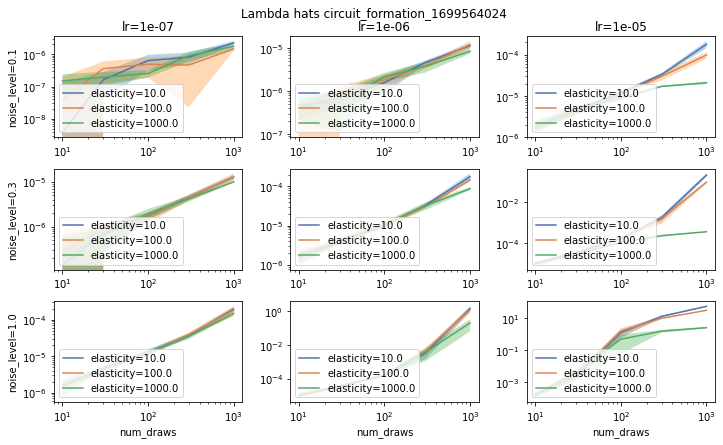

memorization_1699560674


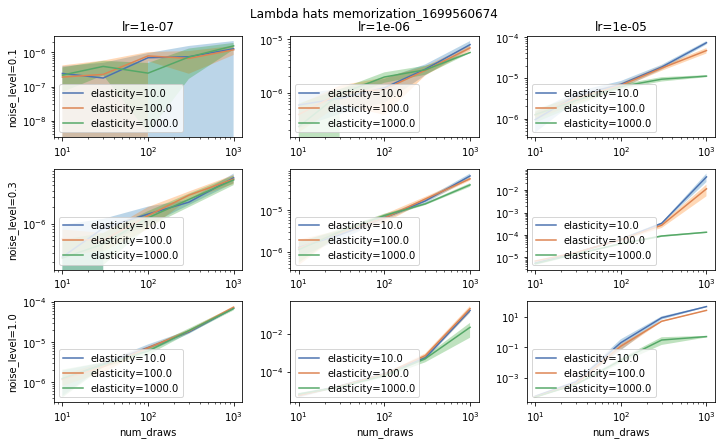

cleanup_1699567342


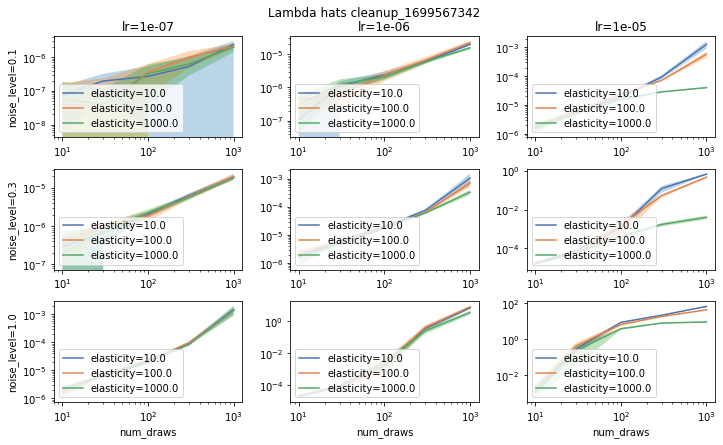

In [49]:
for subdir in subdirs:
    print(subdir)
    grid_search = torch.load(high_level_root/root_folder/subdir/"grokking-rlct-sweep.pt")# lr, num_draws, noise_level, elasticity
    plot_rlct_grid(
        grid_search,
        col_axis="lr",
        row_axis="noise_level",
        x_axis="num_draws",
        label_axis="elasticity",
        title=f"Lambda hats {subdir}",
        NUM_PARAMS=NUM_PARAMS
    )

In [53]:
# seems like best hyperparams are the same for all 3 settings
hparam_base = {'noise_level':1.0, 'lr':1e-5, 'elasticity':10.0, 'num_draws':1000}

In [54]:
# separate in case future expts require diff params
hparam_dicts = {'memorization': hparam_base, 'circuit_formation': hparam_base, 'cleanup': hparam_base}

In [61]:
for subdir in subdirs:
    subdir_strip = '_'.join(subdir.split('_')[:-1])
    folder_root =  high_level_root/root_folder/subdir
    save_dict = torch.load(folder_root/"final.pth", map_location=torch.device('cpu'))
    if not os.path.exists(folder_root/"evals_over_time.pt"):
        # TODO: DRY
        initial_save_dict =  torch.load(folder_root/'init.pth', map_location=torch.device('cpu'))
        trainset = ModuloData(initial_save_dict['train_data'], config)
        total_size = len(initial_save_dict['train_data'])
        batch_size = 2**(len(bin(total_size))-2)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
        
        checkpoint_paths = [folder_root/f"{epoch}.pth" for epoch in epochs]
        hparam_dict = hparam_dicts[subdir_strip]
        evals_over_time = eval_rlcts_over_time(
            trainloader,
            model,
            checkpoint_paths,
            num_draws=hparam_dict['num_draws'],
            num_chains=1,
            num_cores=NUM_CORES,
            lr=hparam_dict['lr'],
            noise_level=hparam_dict['noise_level'],
            weight_decay=3e-7,
            elasticity=hparam_dict['elasticity'],
            repeats=1,
            pbar=True,
        )
        torch.save(evals_over_time, folder_root/"evals_over_time.pt")
        torch.cuda.empty_cache()

In [68]:
def lines(lines_list, x=None, mode='lines', line_labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, return_fig = False, secondary_y=[], secondary_label="", **kwargs):
    '''Helper function to plot multiple lines'''
    labels = line_labels
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    if secondary_label:
        fig = make_subplots(specs=[[{"secondary_y": True}]])
    else:
        fig = go.Figure(layout={'title':title})
    fig.update_layout(title=title)
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if secondary_label:
        fig.add_trace(go.Scatter(x=x, y=secondary_y, name=secondary_label),secondary_y=True,)
        fig.update_yaxes(title_text=secondary_label, secondary_y=True)

    if log_y:
        fig.update_layout(yaxis_type="log")
    if return_fig:
        return fig
    fig.show()

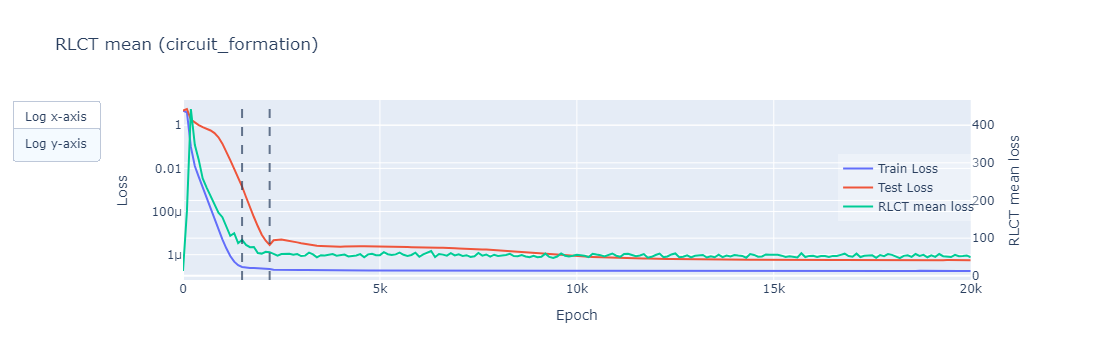

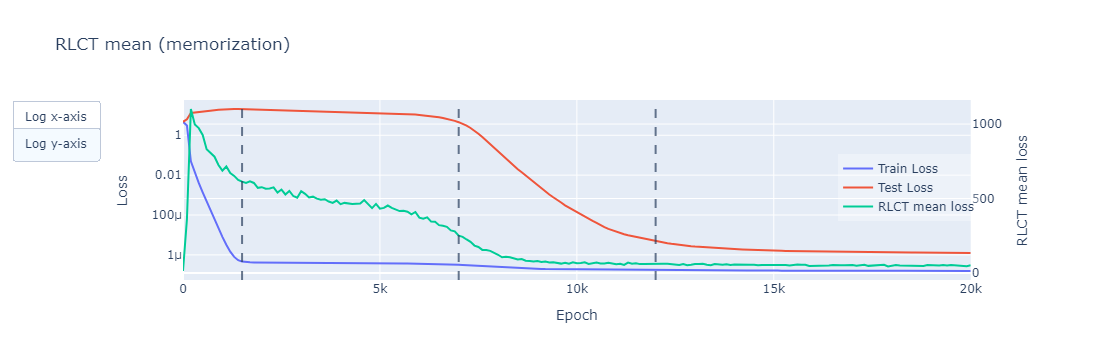

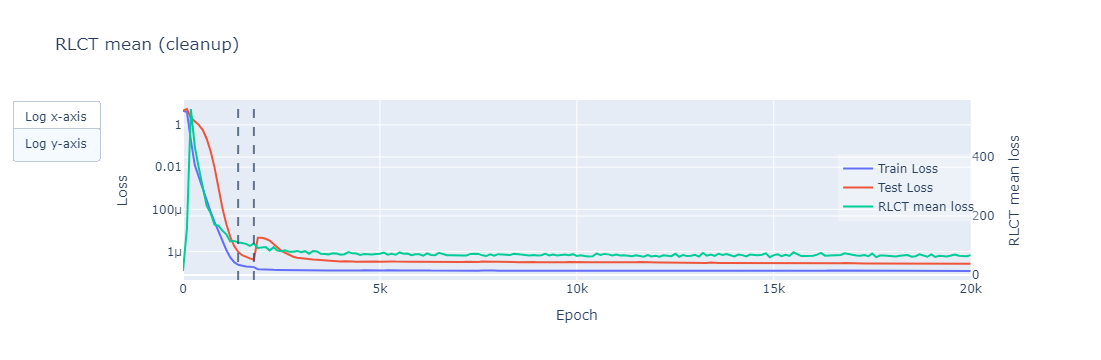

In [70]:
for subdir in subdirs:
    subdir_strip = '_'.join(subdir.split('_')[:-1])
    folder_root =  high_level_root/root_folder/subdir
    save_dict = torch.load(folder_root/"final.pth", map_location=torch.device('cpu'))
    evals_over_time = torch.load(folder_root/"evals_over_time.pt")

    test_losses = [save_dict['test_losses'][epoch] for epoch in epochs]
    train_losses = [save_dict['train_losses'][epoch] for epoch in epochs]
    legend_in_plot_dict = {'xanchor': 'right',
     'x': 0.95,
     'title': '',
     'orientation': 'v',
     'y': .7,
     'yanchor': 'top',
     'bgcolor': 'rgba(255, 255, 255, 0.3)'}
    fig = lines([train_losses,  test_losses],
          line_labels=['Train Loss', 'Test Loss'],
                # labels=['Excluded Loss', 'Train Loss', 'Test Loss'],
          title='RLCT mean' + f' ({subdir_strip})',
          log_y=True,
          x=epochs,
          xaxis='Epoch',
          yaxis='Loss',
          return_fig = True,
               secondary_y = evals_over_time['rlct/mean'],
               secondary_label = "RLCT mean loss")
    fig.update_layout(legend=legend_in_plot_dict)
    # fig.show("vscode+colab")
    # write_image(fig, f'rlct_{subdir_strip}')
    positions = pos_dict[subdir_strip]
    
    for pos in positions:
        fig.add_vline(pos,
                      line_dash='dash',
                      opacity=0.7)
    add_axis_toggle(fig.layout, 'x')
    add_axis_toggle(fig.layout, 'y')
    # fig.show("vscode+colab")
    write_image(fig, f'rlct_{subdir_strip}')